# Tools for extracting NIRSpec spectra from 2D cutouts

*msaexp code and notebook by Gabe Brammer with small additions by Dan Coe*

Gabe Brammer's example notebooks analyzing NIRSpec MSA data with msaexp:  
https://github.com/gbrammer/msaexp

from Dan Coe's GO 1433:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/drizzled-nirspec.ipynb

from Pat Kelly's DD 2756:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-rxj2129.ipynb

from the ERO SMACS0723:  
https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb

JWST Cosmic Spring Github including notebooks like this one:  
https://github.com/cosmic-spring

In [1]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

(not on a codespace)


In [2]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import astropy.units as u
from astropy.coordinates import SkyCoord

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
from jwst.datamodels import SlitModel

import msaexp
from msaexp import pipeline, msa
import msaexp.drizzle
#reload(msaexp.drizzle)
#reload(msaexp.utils)

print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')
print(f'matplotlib version = {matplotlib.__version__}')

grizli version = 1.7.5
msaexp version = 0.6.0
matplotlib version = 3.7.0


In [3]:
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

## Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
prog = 1433
outroot = 'macs0647'
file_version = 'v1'
os.getcwd()

'/Users/dcoe/macs0647/MSA/dataObs23'

In [5]:
# Query MAST and download NIRSpec data for a program name
masks = pipeline.query_program(prog, download=True)

2023-07-06 20:33:58,733 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [6]:
files = glob.glob(f'jw0{prog}*rate.fits')

groups = pipeline.exposure_groups(files=files)

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   1  jw01433021001-01-clear-prism-nrs1
   1  jw01433021001-01-clear-prism-nrs2
   1  jw01433021001-02-clear-prism-nrs1
   1  jw01433021001-02-clear-prism-nrs2
   3  jw01433023001-01-clear-prism-nrs1
   3  jw01433023001-01-clear-prism-nrs2

Files:
jw01433021001-01-clear-prism-nrs1:
- jw01433021001_03101_00001_nrs1_rate.fits
jw01433021001-01-clear-prism-nrs2:
- jw01433021001_03101_00001_nrs2_rate.fits
jw01433021001-02-clear-prism-nrs1:
- jw01433021001_05101_00001_nrs1_rate.fits
jw01433021001-02-clear-prism-nrs2:
- jw01433021001_05101_00001_nrs2_rate.fits
jw01433023001-01-clear-prism-nrs1:
- jw01433023001_04101_00002_nrs1_rate.fits
- jw01433023001_04101_00003_nrs1_rate.fits
- jw01433023001_04101_00001_nrs1_rate.fits
jw01433023001-01-clear-prism-nrs2:
- jw01433023001_04101_00001_nrs2_rate.fits
- jw01433023001_04101_00002_nrs2_rate.fits
- jw01433023001_04101_00003_nrs2_rate.fits



In [7]:
exposure_files = list(groups)
exposure_files.sort()
exposure_files

['jw01433021001-01-clear-prism-nrs1',
 'jw01433021001-01-clear-prism-nrs2',
 'jw01433021001-02-clear-prism-nrs1',
 'jw01433021001-02-clear-prism-nrs2',
 'jw01433023001-01-clear-prism-nrs1',
 'jw01433023001-01-clear-prism-nrs2']

In [8]:
meta_files = glob.glob(f'jw0{prog}*msa.fits')
meta_files = list(np.sort(meta_files))
meta_files

['jw01433021001_01_msa.fits',
 'jw01433021001_02_msa.fits',
 'jw01433023001_01_msa.fits']

In [9]:
#observation = '21001'
#detector = 'nrs2'

In [10]:
meta = msa.MSAMetafile(meta_files[0])

## Plot slitlets

In [11]:
import PIL
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow it to load large image

In [54]:
# Load color image
#color_image_file = '/Users/dcoe/macs0647/v5/color/macs0647_color.png'
color_image_file = '/Users/dcoe/macs0647/color/macs0647_color.png'  # v4 catalog
#color_image_file = '/Users/dcoe/RELICS/data/whl0137-08/JWST/color/whl0137_v4_bright.png'
im = Image.open(color_image_file)
im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
color_image = np.asarray(im)
color_image.shape

2023-07-06 21:07:14,762 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_55057/3164037874.py:6: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  im = im.transpose(method=Image.FLIP_TOP_BOTTOM)



(24576, 16384, 3)

In [55]:
# Load FITS image
#from glob import glob
fits_image_file = glob.glob('/Users/dcoe/macs0647/images/20mas/*.fits')[-1]
#fits_image_file = glob.glob('/Users/dcoe/macs0647/v5/images/20mas/*.fits')[-1]
#fits_image_file = glob.glob('/Users/dcoe/whl0137-08/JWST/images/grizli_v4/20mas/*.fits')[-1]
fits_image_file  # for RA, Dec -> x, y

'/Users/dcoe/macs0647/images/20mas/macs0647-grizli-v4.0-f356w-clear_20mas_sci.fits'

In [56]:
from astropy.io import fits
import astropy.wcs as wcs

hdu = fits.open(fits_image_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 101.9482378  70.2297032  
CRPIX : 8191.5  12287.5  
CD1_1 CD1_2  : -5.5555555555555e-06  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555555e-06  
NAXIS : 16384  24576

In [16]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [17]:
def get_obs_exp(meta_file):
    obs_num = int(meta_file.split('_')[0][-5:-3])
    exp_num = int(meta_file.split('_')[1])
    return obs_num, exp_num

In [18]:
def extract_slitlets(id):
    slitlets_radec = []
    obs_nums = []
    exp_nums = []

    for meta_file in meta_files:
        obs_num, exp_num = get_obs_exp(meta_file)
        obs_nums.append(obs_num)
        exp_nums.append(exp_num)
        
        meta = msa.MSAMetafile(meta_file)
        slits = meta.regions_from_metafile(dither_point_index=1, as_string=False, with_bars=True)
        for s in slits:
            if s.meta['source_id'] in [id]:
                radec = s.xy[0]
                slitlets_radec.append(radec)

    return obs_nums, exp_nums, slitlets_radec        

In [21]:
meta.src_table#[:2]

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
1433,2883,1433_2883,2883,101.968846,70.229727,None,-1.0
1433,2901,1433_2901,2901,101.956138,70.23049,None,-1.0
1433,2914,1433_2914,2914,101.948063,70.230998,None,-1.0
1433,2965,1433_2965,2965,101.958365,70.232297,None,-1.0
1433,2992,1433_2992,2992,101.934979,70.232899,None,-1.0
1433,3088,1433_3088,3088,101.933369,70.234918,None,-1.0
1433,3089,1433_3089,3089,101.93165,70.235244,None,-1.0
1433,3097,1433_3097,3097,101.955782,70.235508,None,-1.0
...,...,...,...,...,...,...,...


In [68]:
meta = msa.MSAMetafile(meta_files[0]) # Obs 21
#meta = msa.MSAMetafile(meta_files[-1]) # Obs 23
meta.src_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
1433,2883,1433_2883,2883,101.968846,70.229727,None,-1.0
1433,2901,1433_2901,2901,101.956138,70.23049,None,-1.0
1433,2914,1433_2914,2914,101.948063,70.230998,None,-1.0
1433,2965,1433_2965,2965,101.958365,70.232297,None,-1.0
1433,2992,1433_2992,2992,101.934979,70.232899,None,-1.0
1433,3088,1433_3088,3088,101.933369,70.234918,None,-1.0
1433,3089,1433_3089,3089,101.93165,70.235244,None,-1.0
1433,3097,1433_3097,3097,101.955782,70.235508,None,-1.0
...,...,...,...,...,...,...,...


In [43]:
extract_slitlets(731)

([21, 21, 23],
 [1, 2, 1],
 [array([[101.91391516,  70.19327897],
         [101.91387675,  70.19334283],
         [101.91427735,  70.1933725 ],
         [101.91431575,  70.19330864]]),
  array([[101.91434408,  70.19331074],
         [101.91430567,  70.1933746 ],
         [101.91470624,  70.19340426],
         [101.91474464,  70.1933404 ]]),
  array([[101.91477296,  70.1933425 ],
         [101.91473456,  70.19340635],
         [101.91513509,  70.19343601],
         [101.91517349,  70.19337216]])])

In [69]:
targets = np.array(meta.src_table['source_id']).astype(int)
targets

array([ 2883,  2901,  2914,  2965,  2992,  3088,  3089,  3097,  3184,
        3208,  3258,  3260,  3308,  3349,  3370,  3379,  3414,  3457,
        3466,  3493,  3501,  3502,  3593,  3598,  3621,  3622,  3634,
        3642,  3723,  3737,  3746,  3754,  3755,  3777,  3778,  3804,
        3826,  3901,  3975,  3989,  4111,  4124,  4142,  4238,  4248,
        4276,  4298,  4323,  4408,  4455,  4494,  4522,  4554,  4622,
        4681,  4719,  4747,  4933,  4945,  4962,  5048,  5082,  5089,
        5121,  5271,  5397,  5408, 50820, 50821, 50938, 50939, 50942,
       50976, 50978, 50981, 50983, 51009, 51015, 51067, 51085, 51088,
       51089, 51102, 51104, 51122, 51131, 51161, 51169, 51170, 51180,
       51190, 51191, 51208, 51209, 51212, 51225, 51233, 51243, 51248,
       51251, 51288, 51290, 51305, 51313, 51314, 51328, 51330, 51345,
       51348, 51349, 51356, 51368, 51385, 51388, 51393, 51394, 51407,
       51414, 51415, 51416, 51417, 51433, 51451, 51469, 51471, 51489,
       51490, 51491,

In [ ]:
#targets = np.loadtxt('targets.txt').astype(int)
#targets = np.sort(targets)
#targets

In [45]:
def export_slitlets(ids):
    outdata = []
    for id in ids:
        print(id)
        for meta_file in meta_files:
            obs_num, exp_num = get_obs_exp(meta_file)
            meta = msa.MSAMetafile(meta_file)
            slits = meta.regions_from_metafile(dither_point_index=1, as_string=False, with_bars=True)
            for s in slits:
                if s.meta['source_id'] in [id]:
                    radec = s.xy[0]
                    ra, dec = radec.T
                    slit_coordinates = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
                    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
                    outline = np.concatenate([np.array([id, obs_num, exp_num]), ra, dec, x, y])
                    outdata.append(outline)
    return outdata

In [70]:
slitlet_data = export_slitlets(targets)

2883
2901
2914
2965
2992
3088
3089
3097
3184
3208
3258
3260
3308
3349
3370
3379
3414
3457
3466
3493
3501
3502
3593
3598
3621
3622
3634
3642
3723
3737
3746
3754
3755
3777
3778
3804
3826
3901
3975
3989
4111
4124
4142
4238
4248
4276
4298
4323
4408
4455
4494
4522
4554
4622
4681
4719
4747
4933
4945
4962
5048
5082
5089
5121
5271
5397
5408
50820
50821
50938
50939
50942
50976
50978
50981
50983
51009
51015
51067
51085
51088
51089
51102
51104
51122
51131
51161
51169
51170
51180
51190
51191
51208
51209
51212
51225
51233
51243
51248
51251
51288
51290
51305
51313
51314
51328
51330
51345
51348
51349
51356
51368
51385
51388
51393
51394
51407
51414
51415
51416
51417
51433
51451
51469
51471
51489
51490
51491
51494
51495
51496
51497
51500
51539
51540
51583
81922
82724
83058


In [71]:
columns = 'id obs exp'.split()
for label in 'ra dec x y'.split():
    for i in range(1,5):
        name = label+'%d' % i
        columns.append(name)
        
#columns

In [72]:
from astropy.table import Table

In [73]:
outtable = Table(np.array(slitlet_data), names=columns)

In [74]:
for column in list(outtable.columns):
    if 'ra' in column:
        outtable[column].format = '.8f'
    elif 'dec' in column:
        outtable[column].format = '.8f'
    elif 'x' in column:
        outtable[column].format = '.2f'
    elif 'y' in column:
        outtable[column].format = '.2f'
    else:
        outtable[column].format = '.0f'

In [75]:
outtable

id,obs,exp,ra1,ra2,ra3,ra4,dec1,dec2,dec3,dec4,x1,x2,x3,x4,y1,y2,y3,y4
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2883,21,1.00,101.96866431,101.96877441,101.96910265,101.96899255,70.22975114,70.22980376,70.22972663,70.22967402,6946.83,6940.13,6920.14,6926.84,12295.34,12304.81,12290.93,12281.46
2883,21,2.00,101.96866431,101.96877441,101.96910265,101.96899255,70.22975114,70.22980376,70.22972663,70.22967402,6946.83,6940.13,6920.14,6926.84,12295.34,12304.81,12290.93,12281.46
2901,21,1.00,101.95599692,101.95610718,101.95643633,101.95632607,70.23047036,70.23052302,70.23044580,70.23039314,7718.10,7711.39,7691.35,7698.06,12424.62,12434.10,12420.20,12410.72
2901,21,2.00,101.95599692,101.95610718,101.95643633,101.95632607,70.23047036,70.23052302,70.23044580,70.23039314,7718.10,7711.39,7691.35,7698.06,12424.62,12434.10,12420.20,12410.72
2965,21,1.00,101.95823246,101.95834267,101.95867181,101.95856161,70.23229153,70.23234419,70.23226691,70.23221426,7582.05,7575.34,7555.30,7562.01,12752.45,12761.93,12748.02,12738.54
2965,21,2.00,101.95823246,101.95834267,101.95867181,101.95856161,70.23229153,70.23234419,70.23226691,70.23221426,7582.05,7575.34,7555.30,7562.01,12752.45,12761.93,12748.02,12738.54
2992,21,1.00,101.93478028,101.93489078,101.93522156,101.93511106,70.23291454,70.23296728,70.23288986,70.23283712,9009.73,9003.00,8982.87,8989.60,12864.63,12874.12,12860.18,12850.69
2992,21,2.00,101.93478028,101.93489078,101.93522156,101.93511106,70.23291454,70.23296728,70.23288986,70.23283712,9009.73,9003.00,8982.87,8989.60,12864.63,12874.12,12860.18,12850.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [76]:
outtable.write('MACS0647-Obs21_NIRSpec_slitlets.dat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

# Draw slitlets

In [58]:
outdata = []

def plot_slitlets(id, name='', obsnum=None, filetype='png'):
    slitlets_radec = []

    #meta = msa.MSAMetafile(pipe.msametfl)
    for meta_file in meta_files:
        meta = msa.MSAMetafile(meta_file)
        slits = meta.regions_from_metafile(dither_point_index=1, as_string=False, with_bars=True)
        for s in slits:
            if s.meta['source_id'] in [id]:
                radec = s.xy[0]
                slitlets_radec.append(radec)
                ra, dec = radec.T
                slit_coordinates = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
                xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
                print('x = ', x)
                print('y = ', y)
                print('ra = ', ra)
                print('dec = ', dec)
                outline = np.concatenate([np.array([id]), ra, dec, x, y])
                outdata.append(outline)
                if s.meta['is_source']:
                    slices, extent = slices_extent(np.mean(x), np.mean(y), 50)

    if slitlets_radec:  # else not found
        fig = plt.figure(figsize=(9.5, 6))
        ax = fig.add_subplot(1, 1, 1) #, projection=imwcs) # , sharex=True, sharey=True)
        ax.imshow(color_image[slices], extent=extent, origin='lower')

        for radec in slitlets_radec:
            ra, dec = radec.T
            slit_coordinates = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
            xy = np.array(xy).T  # (4, 2)
            #print(np.mean(x), np.mean(y))
            patch = matplotlib.patches.Polygon(xy, fc='None', ec='r', alpha=1, zorder=100)
            ax.add_patch(patch)

        if name:
            label = name + ' '
        else:
            label = ''
        label += ' #%d' % id
        if obsnum:
            label += '\nObs %d' % obsnum
        if 0:
            plt.text(0.05, 0.95, label, color='w', fontsize=36, fontweight='bold', va='top', transform=ax.transAxes)

        #plt.text(0.05, 0.90, label, color='w', fontsize=36, fontweight='bold', va='top', transform=ax.transAxes)

        ax.axis('off')

        #outfile = 'slitlets_%d_Obs%d.pdf' % (id, obsnum)
        outfile = 'slitlets_%d' % id
        if obsnum:
            outfile += '_Obs%d' % obsnum

        outfile += '.' + filetype  # png / pdf

        plt.savefig(outfile, bbox_inches='tight', dpi=800)
        plt.show()

x =  [10968.39138721 10970.75025012 10946.2815541  10943.92274113]
y =  [7608.54422074 7620.02335942 7625.28589794 7613.80717245]
ra =  [101.90267011 101.90263127 101.90303259 101.90307142]
dec =  [70.20370878 70.20377255 70.20380189 70.20373812]
x =  [10942.19271106 10944.55152049 10920.08498032 10917.72622085]
y =  [7614.17928032 7625.6579766  7630.91994837 7619.44166528]
ra =  [101.9030998  101.90306096 101.90346224 101.90350107]
dec =  [70.2037402  70.20380396 70.20383329 70.20376953]
x =  [10915.99634321 10918.35509915 10893.89071482 10891.53200885]
y =  [7619.81373306 7631.29198695 7636.55339193 7625.07555123]
ra =  [101.90352945 101.90349062 101.90389186 101.90393069]
dec =  [70.20377161 70.20383537 70.2038647  70.20380094]


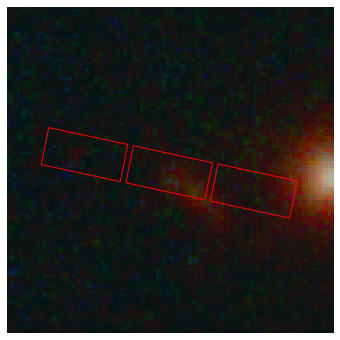

In [59]:
#plot_slitlets(2883, obsnum=21)
plot_slitlets(1395)

x =  [6946.83417327 6940.1340111  6920.14484163 6926.8447741 ]
y =  [12295.33855799 12304.81088402 12290.93460956 12281.46250897]
ra =  [101.96866431 101.96877441 101.96910265 101.96899255]
dec =  [70.22975114 70.22980376 70.22972663 70.22967402]
x =  [6946.83417327 6940.1340111  6920.14484163 6926.8447741 ]
y =  [12295.33855799 12304.81088402 12290.93460956 12281.46250897]
ra =  [101.96866431 101.96877441 101.96910265 101.96899255]
dec =  [70.22975114 70.22980376 70.22972663 70.22967402]


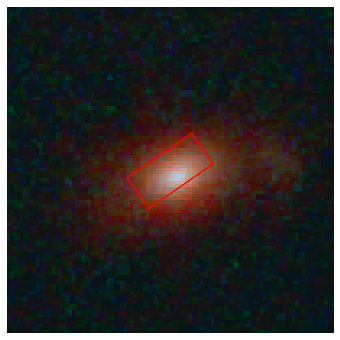

x =  [7718.10342769 7711.39197038 7691.35056576 7698.06179321]
y =  [12424.61917433 12434.09860446 12420.20138098 12410.72217609]
ra =  [101.95599692 101.95610718 101.95643633 101.95632607]
dec =  [70.23047036 70.23052302 70.2304458  70.23039314]
x =  [7718.10342769 7711.39197038 7691.35056576 7698.06179321]
y =  [12424.61917433 12434.09860446 12420.20138098 12410.72217609]
ra =  [101.95599692 101.95610718 101.95643633 101.95632607]
dec =  [70.23047036 70.23052302 70.2304458  70.23039314]


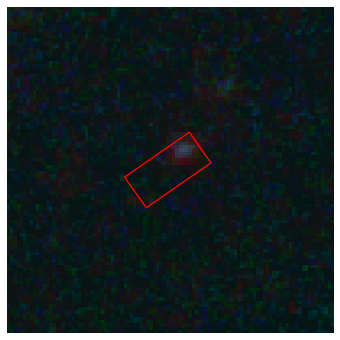

x =  [7582.05112813 7575.34377152 7555.30416424 7562.01129101]
y =  [12752.44997304 12761.92951416 12748.02251341 12738.54319756]
ra =  [101.95823246 101.95834267 101.95867181 101.95856161]
dec =  [70.23229153 70.23234419 70.23226691 70.23221426]
x =  [7582.05112813 7575.34377152 7555.30416424 7562.01129101]
y =  [12752.44997304 12761.92951416 12748.02251341 12738.54319756]
ra =  [101.95823246 101.95834267 101.95867181 101.95856161]
dec =  [70.23229153 70.23234419 70.23226691 70.23221426]


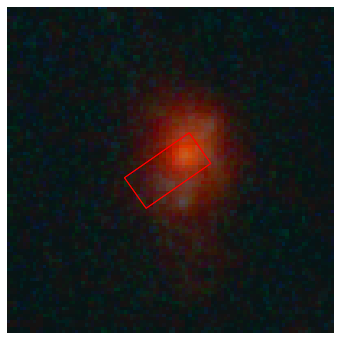

x =  [9009.73386453 9003.00488009 8982.87163452 8989.60038883]
y =  [12864.63211789 12874.12425508 12860.18342318 12850.6915109 ]
ra =  [101.93478028 101.93489078 101.93522156 101.93511106]
dec =  [70.23291454 70.23296728 70.23288986 70.23283712]
x =  [9009.73386453 9003.00488009 8982.87163452 8989.60038883]
y =  [12864.63211789 12874.12425508 12860.18342318 12850.6915109 ]
ra =  [101.93478028 101.93489078 101.93522156 101.93511106]
dec =  [70.23291454 70.23296728 70.23288986 70.23283712]


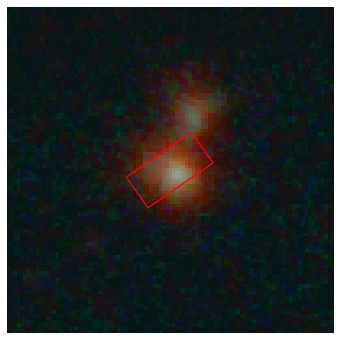

x =  [9107.7958917  9101.06754956 9080.92049904 9087.64861104]
y =  [13225.24913296 13234.74349724 13220.78681673 13211.29267732]
ra =  [101.93316795 101.93327845 101.93360949 101.93349899]
dec =  [70.23491784 70.2349706  70.23489309 70.23484033]
x =  [9107.7958917  9101.06754956 9080.92049904 9087.64861104]
y =  [13225.24913296 13234.74349724 13220.78681673 13211.29267732]
ra =  [101.93316795 101.93327845 101.93360949 101.93349899]
dec =  [70.23491784 70.2349706  70.23489309 70.23484033]


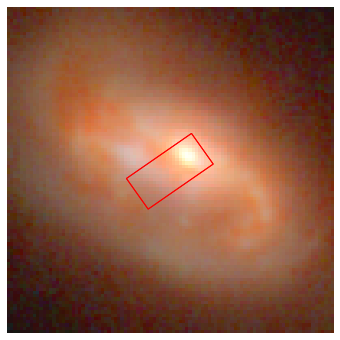

x =  [9223.41392432 9216.68416369 9196.52841207 9203.25794252]
y =  [13289.07185677 13298.56744827 13284.60593533 13275.11056867]
ra =  [101.93126822 101.93137874 101.93170994 101.93159942]
dec =  [70.23527224 70.23532501 70.23524747 70.23519471]
x =  [9223.41392432 9216.68416369 9196.52841207 9203.25794252]
y =  [13289.07185677 13298.56744827 13284.60593533 13275.11056867]
ra =  [101.93126822 101.93137874 101.93170994 101.93159942]
dec =  [70.23527224 70.23532501 70.23524747 70.23519471]


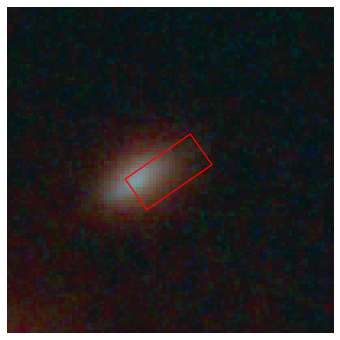

x =  [7745.03784943 7738.33145985 7718.26910761 7724.97526733]
y =  [13336.64071521 13346.123914   13332.19111607 13322.70814251]
ra =  [101.95555632 101.95566652 101.9559961  101.9558859 ]
dec =  [70.23553717 70.23558985 70.23551243 70.23545975]
x =  [7745.03784943 7738.33145985 7718.26910761 7724.97526733]
y =  [13336.64071521 13346.123914   13332.19111607 13322.70814251]
ra =  [101.95555632 101.95566652 101.9559961  101.9558859 ]
dec =  [70.23553717 70.23558985 70.23551243 70.23545975]


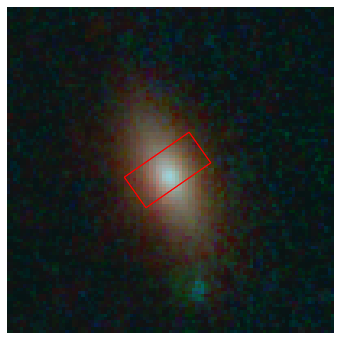

x =  [8710.90759495 8704.18800006 8684.05737981 8690.77674463]
y =  [13649.42459822 13658.91723185 13644.95249265 13635.46008399]
ra =  [101.93968727 101.93979766 101.94012844 101.94001806]
dec =  [70.2372748  70.23732754 70.23724998 70.23719724]
x =  [8710.90759495 8704.18800006 8684.05737981 8690.77674463]
y =  [13649.42459822 13658.91723185 13644.95249265 13635.46008399]
ra =  [101.93968727 101.93979766 101.94012844 101.94001806]
dec =  [70.2372748  70.23732754 70.23724998 70.23719724]


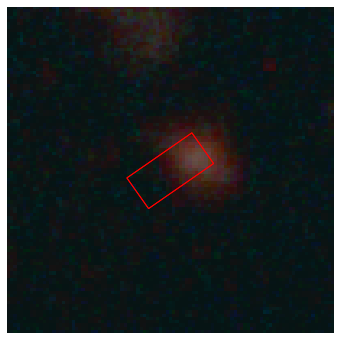

x =  [10030.31620182 10032.74468317 10008.41169855 10005.98333164]
y =  [13698.55891698 13709.98121372 13714.99506963 13703.5731813 ]
ra =  [101.91800841 101.91796841 101.91836818 101.91840817]
dec =  [70.23754543 70.23760888 70.23763681 70.23757336]
x =  [10004.26290428 10006.69126309  9982.36050203  9979.93225768]
y =  [13703.92771068 13715.34957013 13720.36301413 13708.94156308]
ra =  [101.91843644 101.91839645 101.91879618 101.91883617]
dec =  [70.23757533 70.23763878 70.2376667  70.23760325]
x =  [9978.21198754 9980.6402238  9956.31168629 9953.8835645 ]
y =  [13709.29606334 13720.71748551 13725.73051754 13714.30950377]
ra =  [101.91886443 101.91882444 101.91922414 101.91926412]
dec =  [70.23760523 70.23766867 70.23769659 70.23763314]


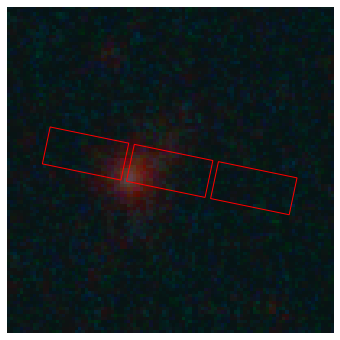

x =  [7830.18729269 7823.48266789 7803.40407399 7810.10846892]
y =  [13850.7771924  13860.26310721 13846.30883272 13836.82314311]
ra =  [101.95415822 101.9542684  101.9545983  101.95448812]
dec =  [70.23839353 70.23844623 70.23836869 70.238316  ]
x =  [7830.18729269 7823.48266789 7803.40407399 7810.10846892]
y =  [13850.7771924  13860.26310721 13846.30883272 13836.82314311]
ra =  [101.95415822 101.9542684  101.9545983  101.95448812]
dec =  [70.23839353 70.23844623 70.23836869 70.238316  ]


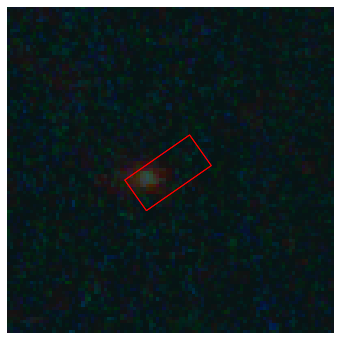

x =  [6627.36961469 6620.68288738 6600.68461407 6607.37111178]
y =  [13696.34732414 13705.82235416 13691.89885674 13682.42405223]
ra =  [101.97392105 101.97403098 101.97435947 101.97424954]
dec =  [70.23753385 70.23758648 70.23750908 70.23745645]
x =  [6627.36961469 6620.68288738 6600.68461407 6607.37111178]
y =  [13696.34732414 13705.82235416 13691.89885674 13682.42405223]
ra =  [101.97392105 101.97403098 101.97435947 101.97424954]
dec =  [70.23753385 70.23758648 70.23750908 70.23745645]


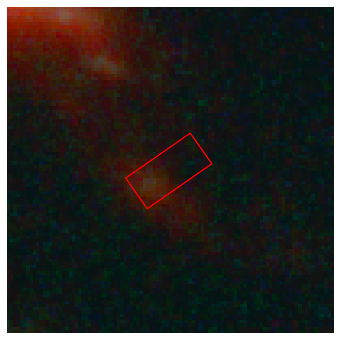

x =  [7942.20362706 7935.49820976 7915.40912168 7922.11430909]
y =  [14009.89528603 14019.38277072 14005.42008538 13995.93282585]
ra =  [101.95231782 101.95242801 101.9527581  101.95264791]
dec =  [70.23927757 70.23933028 70.2392527  70.23919999]
x =  [7942.20362706 7935.49820976 7915.40912168 7922.11430909]
y =  [14009.89528603 14019.38277072 14005.42008538 13995.93282585]
ra =  [101.95231782 101.95242801 101.9527581  101.95264791]
dec =  [70.23927757 70.23933028 70.2392527  70.23919999]


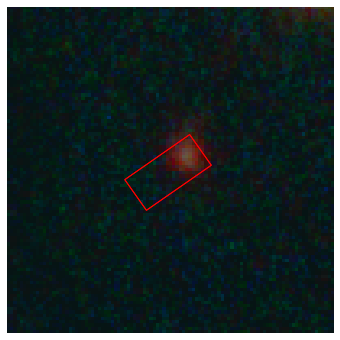

x =  [6796.69168762 6790.00467915 6769.98724445 6776.67402328]
y =  [14090.29716539 14099.7751727  14085.83305733 14076.35527548]
ra =  [101.97114141 101.97125135 101.9715802  101.97147026]
dec =  [70.23972284 70.23977548 70.23969798 70.23964534]
x =  [6796.69168762 6790.00467915 6769.98724445 6776.67402328]
y =  [14090.29716539 14099.7751727  14085.83305733 14076.35527548]
ra =  [101.97114141 101.97125135 101.9715802  101.97147026]
dec =  [70.23972284 70.23977548 70.23969798 70.23964534]
x =  [6814.63110936 6817.04138646 6792.97564011 6790.56549434]
y =  [14075.03349294 14086.40267001 14091.3754217  14080.00653704]
ra =  [101.97084653 101.97080699 101.97120248 101.97124202]
dec =  [70.23963808 70.23970124 70.23972882 70.23966566]
x =  [6788.8639536  6791.27409009 6767.21027863 6764.80027347]
y =  [14080.35815676 14091.72702075 14096.69949931 14085.33092773]
ra =  [101.97126998 101.97123044 101.9716259  101.97166543]
dec =  [70.23966761 70.23973077 70.23975834 70.23969518]
x =  [6763.0

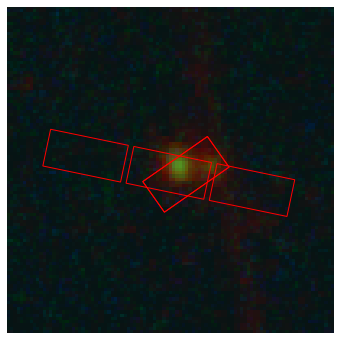

x =  [9393.8657251  9387.13843163 9366.95410115 9373.68116442]
y =  [14139.37519388 14148.87550908 14134.8779292  14125.37783879]
ra =  [101.92846335 101.92857385 101.92890561 101.92879511]
dec =  [70.23999587 70.24004866 70.23997093 70.23991814]
x =  [9393.8657251  9387.13843163 9366.95410115 9373.68116442]
y =  [14139.37519388 14148.87550908 14134.8779292  14125.37783879]
ra =  [101.92846335 101.92857385 101.92890561 101.92879511]
dec =  [70.23999587 70.24004866 70.23997093 70.23991814]


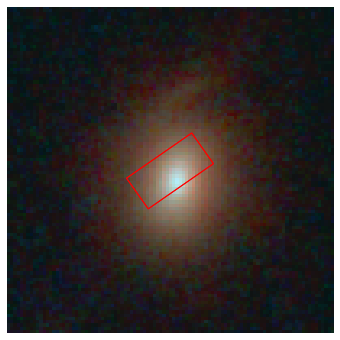

x =  [5639.60678875 5632.93854355 5612.99330923 5619.66132506]
y =  [14192.61558987 14202.08405518 14188.16192535 14178.69368578]
ra =  [101.99015624 101.99026593 101.99059353 101.99048384]
dec =  [70.24028785 70.24034043 70.24026301 70.24021043]
x =  [5639.60678875 5632.93854355 5612.99330923 5619.66132506]
y =  [14192.61558987 14202.08405518 14188.16192535 14178.69368578]
ra =  [101.99015624 101.99026593 101.99059353 101.99048384]
dec =  [70.24028785 70.24034043 70.24026301 70.24021043]


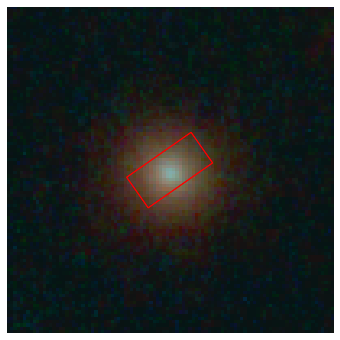

x =  [10140.58729205 10133.84942908 10113.61403103 10120.35166364]
y =  [14315.05417062 14324.56147236 14310.54179602 14301.03471887]
ra =  [101.91619125 101.91630189 101.91663455 101.91652391]
dec =  [70.24097009 70.24102293 70.2409451  70.24089227]
x =  [10140.58729205 10133.84942908 10113.61403103 10120.35166364]
y =  [14315.05417062 14324.56147236 14310.54179602 14301.03471887]
ra =  [101.91619125 101.91630189 101.91663455 101.91652391]
dec =  [70.24097009 70.24102293 70.2409451  70.24089227]


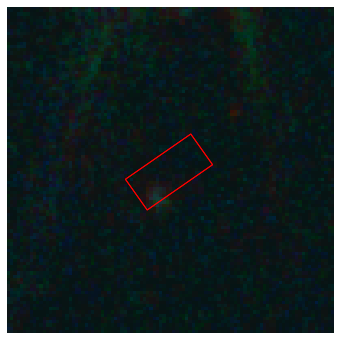

x =  [9384.4500414  9377.72462172 9357.53493622 9364.26012571]
y =  [14425.8206084  14435.32194629 14421.31360513 14411.81249204]
ra =  [101.92861656 101.92872704 101.92905891 101.92894843]
dec =  [70.24158725 70.24164004 70.24156225 70.24150946]
x =  [9384.4500414  9377.72462172 9357.53493622 9364.26012571]
y =  [14425.8206084  14435.32194629 14421.31360513 14411.81249204]
ra =  [101.92861656 101.92872704 101.92905891 101.92894843]
dec =  [70.24158725 70.24164004 70.24156225 70.24150946]


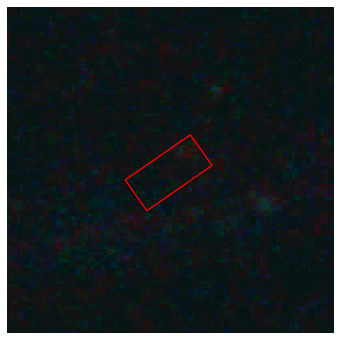

x =  [5399.40700896 5392.74377301 5372.80966874 5379.47267536]
y =  [14398.08321875 14407.55041116 14393.62535675 14384.15839013]
ra =  [101.99410595 101.99421557 101.99454299 101.99443337]
dec =  [70.24142838 70.24148094 70.2414035  70.24135093]
x =  [5399.40700896 5392.74377301 5372.80966874 5379.47267536]
y =  [14398.08321875 14407.55041116 14393.62535675 14384.15839013]
ra =  [101.99410595 101.99421557 101.99454299 101.99443337]
dec =  [70.24142838 70.24148094 70.2414035  70.24135093]


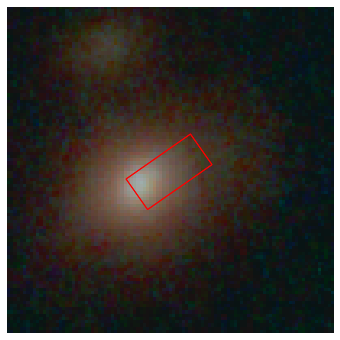

x =  [9913.08783009 9906.35461991 9886.12983452 9892.8628144 ]
y =  [14499.39123838 14508.89732827 14494.87529081 14485.36942557]
ra =  [101.91992843 101.92003901 101.9203715  101.92026092]
dec =  [70.24199481 70.24204764 70.2419698  70.24191697]
x =  [9913.08783009 9906.35461991 9886.12983452 9892.8628144 ]
y =  [14499.39123838 14508.89732827 14494.87529081 14485.36942557]
ra =  [101.91992843 101.92003901 101.9203715  101.92026092]
dec =  [70.24199481 70.24204764 70.2419698  70.24191697]


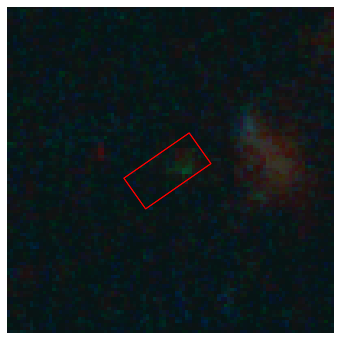

x =  [7184.39369685 7177.70194992 7157.65502091 7164.34653813]
y =  [14311.55031927 14321.03250031 14307.07389476 14297.59193907]
ra =  [101.96477153 101.96488154 101.96521091 101.9651009 ]
dec =  [70.24095272 70.24100539 70.24092781 70.24087514]
x =  [7184.39369685 7177.70194992 7157.65502091 7164.34653813]
y =  [14311.55031927 14321.03250031 14307.07389476 14297.59193907]
ra =  [101.96477153 101.96488154 101.96521091 101.9651009 ]
dec =  [70.24095272 70.24100539 70.24092781 70.24087514]
x =  [7210.80737975 7213.22318529 7189.1289681  7186.71329372]
y =  [14293.29433271 14304.67014095 14309.63904694 14298.26353119]
ra =  [101.96433738 101.96429773 101.9646937  101.96473335]
dec =  [70.24085134 70.24091454 70.24094211 70.24087891]
x =  [7185.00973988 7187.42540499 7163.33312268 7160.91758874]
y =  [14298.61487902 14309.99037409 14314.95900757 14303.58380498]
ra =  [101.96476134 101.9647217  101.96511764 101.96515728]
dec =  [70.24088086 70.24094406 70.24097163 70.24090843]
x =  [7159.2

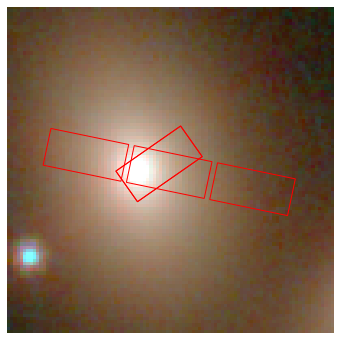

x =  [7273.46640479 7266.77305004 7246.7211613  7253.41428632]
y =  [14276.07377289 14285.55657829 14271.59749409 14262.11491402]
ra =  [101.96330762 101.96341765 101.96374711 101.96363708]
dec =  [70.24075576 70.24080843 70.24073085 70.24067818]
x =  [7273.46640479 7266.77305004 7246.7211613  7253.41428632]
y =  [14276.07377289 14285.55657829 14271.59749409 14262.11491402]
ra =  [101.96330762 101.96341765 101.96374711 101.96363708]
dec =  [70.24075576 70.24080843 70.24073085 70.24067818]


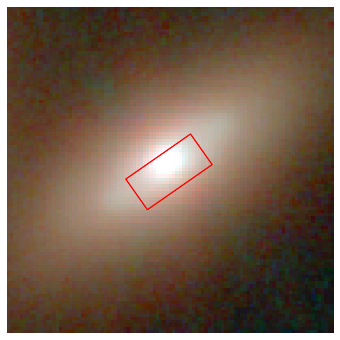

x =  [6124.88029192 6118.20764363 6098.21996435 6104.89238317]
y =  [14726.12680434 14735.60150852 14721.64887825 14712.17439969]
ra =  [101.98218671 101.98229646 101.98262483 101.98251508]
dec =  [70.24325348 70.2433061  70.24322852 70.24317591]
x =  [6124.88029192 6118.20764363 6098.21996435 6104.89238317]
y =  [14726.12680434 14735.60150852 14721.64887825 14712.17439969]
ra =  [101.98218671 101.98229646 101.98262483 101.98251508]
dec =  [70.24325348 70.2433061  70.24322852 70.24317591]
x =  [6144.92977402 6147.34205739 6123.32875896 6120.91660708]
y =  [14717.64712334 14729.01121395 14733.96332767 14722.59952942]
ra =  [101.98185711 101.98181757 101.98221228 101.98225182]
dec =  [70.24320643 70.24326958 70.24329701 70.24323387]
x =  [6119.21877477 6121.63091735 6097.61955295 6095.20754187]
y =  [14722.94968986 14734.31346744 14739.26530701 14727.90182178]
ra =  [101.98227973 101.98224019 101.98263486 101.9826744 ]
dec =  [70.24323581 70.24329895 70.24332639 70.24326325]
x =  [6093.5

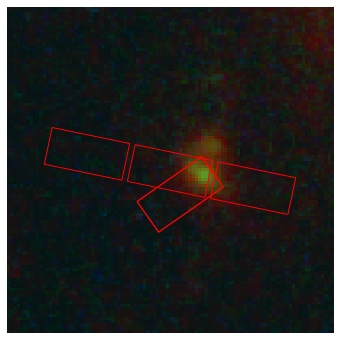

x =  [6613.33295895 6606.65284732 6586.63314335 6593.31302539]
y =  [14758.37675958 14767.85577869 14753.89183081 14744.4130372 ]
ra =  [101.97415911 101.97426896 101.9745979  101.97448804]
dec =  [70.24343398 70.24348663 70.243409   70.24335636]
x =  [6613.33295895 6606.65284732 6586.63314335 6593.31302539]
y =  [14758.37675958 14767.85577869 14753.89183081 14744.4130372 ]
ra =  [101.97415911 101.97426896 101.9745979  101.97448804]
dec =  [70.24343398 70.24348663 70.243409   70.24335636]


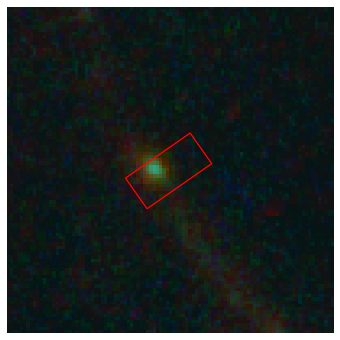

x =  [6106.35798288 6099.6863297  6079.69738246 6086.36880617]
y =  [14843.09817379 14852.57317103 14838.61643741 14829.14166579]
ra =  [101.98249221 101.98260195 101.98293035 101.98282061]
dec =  [70.24390327 70.24395588 70.24387828 70.24382567]
x =  [6106.35798288 6099.6863297  6079.69738246 6086.36880617]
y =  [14843.09817379 14852.57317103 14838.61643741 14829.14166579]
ra =  [101.98249221 101.98260195 101.98293035 101.98282061]
dec =  [70.24390327 70.24395588 70.24387828 70.24382567]


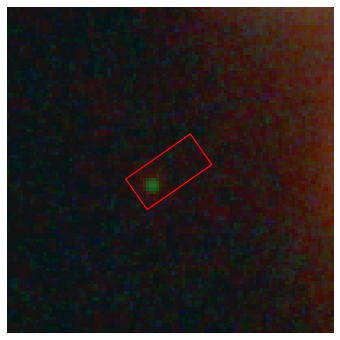

x =  [7761.47619179 7754.77842624 7734.68414375 7741.38167947]
y =  [14810.851706   14820.34074021 14806.35110563 14796.86229662]
ra =  [101.95528906 101.95539916 101.9557294  101.9556193 ]
dec =  [70.24372724 70.24377995 70.24370222 70.24364951]
x =  [7761.47619179 7754.77842624 7734.68414375 7741.38167947]
y =  [14810.851706   14820.34074021 14806.35110563 14796.86229662]
ra =  [101.95528906 101.95539916 101.9557294  101.9556193 ]
dec =  [70.24372724 70.24377995 70.24370222 70.24364951]


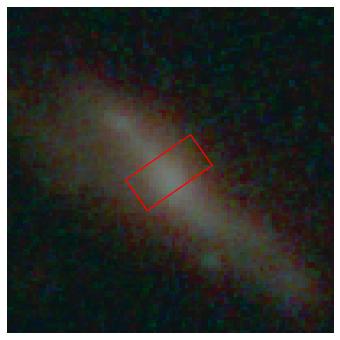

x =  [5938.05854677 5931.38960839 5911.41121317 5918.07992212]
y =  [14855.47001389 14864.943613   14850.98987883 14841.51650539]
ra =  [101.98525845 101.98536816 101.98569638 101.98558668]
dec =  [70.24397145 70.24402406 70.24394647 70.24389386]
x =  [5938.05854677 5931.38960839 5911.41121317 5918.07992212]
y =  [14855.47001389 14864.943613   14850.98987883 14841.51650539]
ra =  [101.98525845 101.98536816 101.98569638 101.98558668]
dec =  [70.24397145 70.24402406 70.24394647 70.24389386]


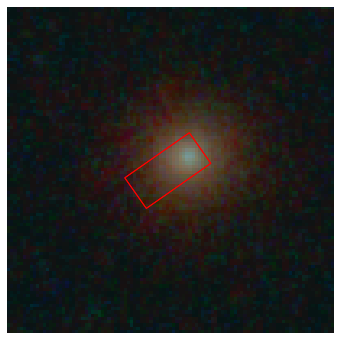

x =  [8773.14048397 8766.42733651 8746.26710024 8752.98001765]
y =  [14880.187096   14889.68500063 14875.67187412 14866.17419443]
ra =  [101.93866158 101.93877189 101.93910328 101.93899297]
dec =  [70.24411232 70.24416509 70.24408726 70.24403449]
x =  [8773.14048397 8766.42733651 8746.26710024 8752.98001765]
y =  [14880.187096   14889.68500063 14875.67187412 14866.17419443]
ra =  [101.93866158 101.93877189 101.93910328 101.93899297]
dec =  [70.24411232 70.24416509 70.24408726 70.24403449]


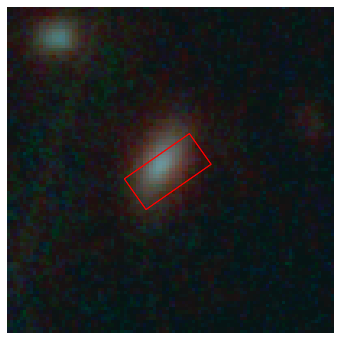

x =  [9507.98343331 9501.25915885 9481.05106869 9487.77511295]
y =  [14934.85606819 14944.36040725 14930.33006794 14920.82595363]
ra =  [101.92658345 101.92669392 101.92702614 101.92691568]
dec =  [70.24441499 70.2444678  70.2443899  70.24433708]
x =  [9507.98343331 9501.25915885 9481.05106869 9487.77511295]
y =  [14934.85606819 14944.36040725 14930.33006794 14920.82595363]
ra =  [101.92658345 101.92669392 101.92702614 101.92691568]
dec =  [70.24441499 70.2444678  70.2443899  70.24433708]


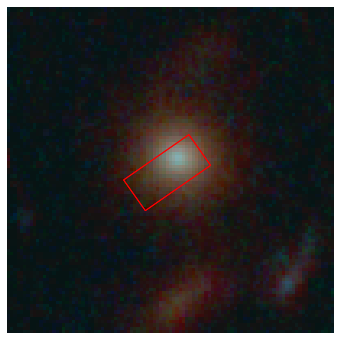

x =  [6921.29784677 6914.61410733 6894.57050959 6901.25401939]
y =  [14956.91052181 14966.39294407 14952.41503655 14942.9328397 ]
ra =  [101.96909871 101.96920862 101.96953798 101.96942808]
dec =  [70.24453761 70.24459027 70.24451258 70.24445991]
x =  [6921.29784677 6914.61410733 6894.57050959 6901.25401939]
y =  [14956.91052181 14966.39294407 14952.41503655 14942.9328397 ]
ra =  [101.96909871 101.96920862 101.96953798 101.96942808]
dec =  [70.24453761 70.24459027 70.24451258 70.24445991]


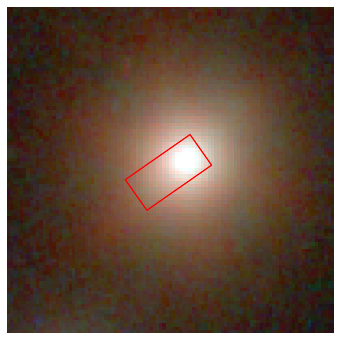

x =  [5175.49215595 5168.83598976 5148.90386699 5155.55980392]
y =  [14987.9617076  14997.42925399 14983.48618178 14974.01886124]
ra =  [101.9977936  101.99790313 101.99823056 101.99812103]
dec =  [70.2447045  70.24475707 70.24467952 70.24462695]
x =  [5175.49215595 5168.83598976 5148.90386699 5155.55980392]
y =  [14987.9617076  14997.42925399 14983.48618178 14974.01886124]
ra =  [101.9977936  101.99790313 101.99823056 101.99812103]
dec =  [70.2447045  70.24475707 70.24467952 70.24462695]


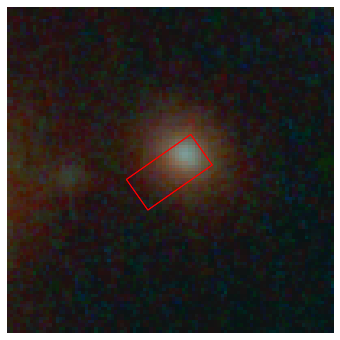

x =  [9896.1336741  9889.40389939 9869.16931203 9875.89885646]
y =  [15025.11715549 15034.62512013 15020.58335031 15011.07561032]
ra =  [101.92020308 101.92031362 101.92064631 101.92053577]
dec =  [70.24491556 70.2449684  70.24489044 70.2448376 ]
x =  [9896.1336741  9889.40389939 9869.16931203 9875.89885646]
y =  [15025.11715549 15034.62512013 15020.58335031 15011.07561032]
ra =  [101.92020308 101.92031362 101.92064631 101.92053577]
dec =  [70.24491556 70.2449684  70.24489044 70.2448376 ]
x =  [9902.85284492 9905.29833923 9880.98633824 9878.54095835]
y =  [15012.31011115 15023.73268962 15028.69625155 15017.27408159]
ra =  [101.92009274 101.92005245 101.92045202 101.9204923 ]
dec =  [70.24484439 70.24490784 70.24493548 70.24487203]
x =  [9876.82201462 9879.26738643 9854.95760748 9852.5123501 ]
y =  [15017.62505482 15029.0471959  15034.01034562 15022.58861304]
ra =  [101.92052055 101.92048027 101.9208798  101.92092008]
dec =  [70.24487398 70.24493743 70.24496507 70.24490162]
x =  [9850.7

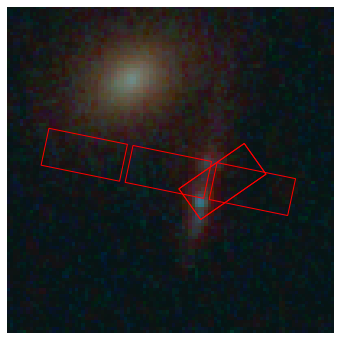

x =  [7237.30856909 7230.62101492 7210.55326692 7217.24059137]
y =  [15144.75104763 15154.23689546 15140.24528093 15130.75965844]
ra =  [101.96390548 101.96401544 101.96434524 101.96423528]
dec =  [70.24558169 70.24563438 70.24555662 70.24550393]
x =  [7237.30856909 7230.62101492 7210.55326692 7217.24059137]
y =  [15144.75104763 15154.23689546 15140.24528093 15130.75965844]
ra =  [101.96390548 101.96401544 101.96434524 101.96423528]
dec =  [70.24558169 70.24563438 70.24555662 70.24550393]
x =  [7254.24366098 7256.66919061 7232.57530722 7230.14990864]
y =  [15130.38085333 15141.76231299 15146.7090191  15135.32785199]
ra =  [101.96362706 101.96358723 101.96398329 101.96402311]
dec =  [70.24550188 70.24556511 70.24559256 70.24552933]
x =  [7228.44637837 7230.87176768 7206.77981846 7204.35456021]
y =  [15135.67763014 15147.05877656 15152.0052102  15140.62435633]
ra =  [101.96405111 101.96401129 101.96440731 101.96444713]
dec =  [70.24553127 70.2455945  70.24562195 70.24555872]
x =  [7202.6

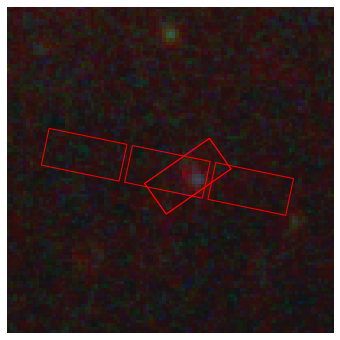

x =  [7464.6343296  7457.94319402 7437.86099789 7444.55190371]
y =  [15140.6388079  15150.12658071 15136.13043975 15126.64289221]
ra =  [101.9601689  101.96027891 101.96060896 101.96049894]
dec =  [70.24555913 70.24561183 70.24553405 70.24548135]
x =  [7464.6343296  7457.94319402 7437.86099789 7444.55190371]
y =  [15140.6388079  15150.12658071 15136.13043975 15126.64289221]
ra =  [101.9601689  101.96027891 101.96060896 101.96049894]
dec =  [70.24555913 70.24561183 70.24553405 70.24548135]
x =  [7469.06129903 7471.4884551  7447.37864626 7444.95162118]
y =  [15127.23491908 15138.61923411 15143.56710996 15132.18308751]
ra =  [101.96009609 101.96005623 101.96045254 101.96049239]
dec =  [70.24548467 70.24554792 70.24557538 70.24551213]
x =  [7443.24696486 7445.67398069 7421.56610613 7419.13922128]
y =  [15132.53294839 15143.91695014 15148.86455386 15137.48084468]
ra =  [101.96052041 101.96048056 101.96087684 101.96091669]
dec =  [70.24551407 70.24557732 70.24560478 70.24554154]


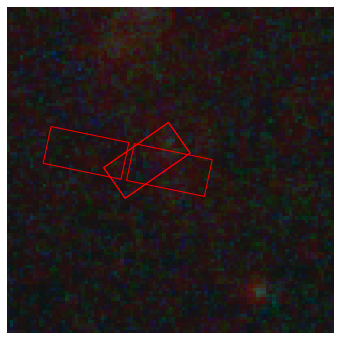

x =  [9631.72513358 9625.00062906 9604.77886464 9611.50313893]
y =  [15216.20708022 15225.71354461 15211.66991504 15202.16367537]
ra =  [101.92454782 101.92465829 101.92499077 101.9248803 ]
dec =  [70.24597779 70.24603062 70.24595264 70.24589982]
x =  [9631.72513358 9625.00062906 9604.77886464 9611.50313893]
y =  [15216.20708022 15225.71354461 15211.66991504 15202.16367537]
ra =  [101.92454782 101.92465829 101.92499077 101.9248803 ]
dec =  [70.24597779 70.24603062 70.24595264 70.24589982]


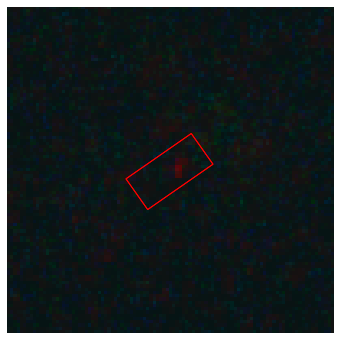

x =  [9511.17855799 9504.45640877 9484.24065855 9490.96257757]
y =  [15295.35194898 15304.85769802 15290.81352485 15281.30800057]
ra =  [101.92652883 101.92663927 101.92697165 101.92686121]
dec =  [70.24641774 70.24647056 70.24639257 70.24633975]
x =  [9511.17855799 9504.45640877 9484.24065855 9490.96257757]
y =  [15295.35194898 15304.85769802 15290.81352485 15281.30800057]
ra =  [101.92652883 101.92663927 101.92697165 101.92686121]
dec =  [70.24641774 70.24647056 70.24639257 70.24633975]


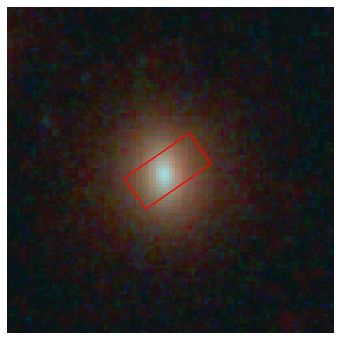

x =  [4828.40178234 4821.75459337 4801.83252388 4808.47948367]
y =  [15572.57350776 15582.04031981 15568.08198399 15558.61539788]
ra =  [102.00350723 102.00361664 102.00394393 102.00383452]
dec =  [70.24795068 70.24800324 70.2479256  70.24787304]
x =  [4828.40178234 4821.75459337 4801.83252388 4808.47948367]
y =  [15572.57350776 15582.04031981 15568.08198399 15558.61539788]
ra =  [102.00350723 102.00361664 102.00394393 102.00383452]
dec =  [70.24795068 70.24800324 70.2479256  70.24787304]


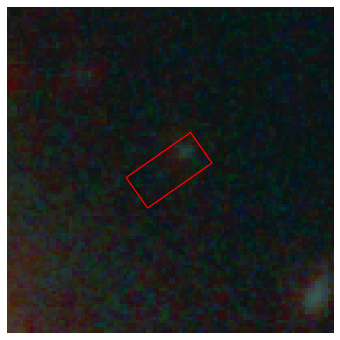

x =  [8782.54521102 8775.83706242 8755.65854817 8762.36646674]
y =  [15733.15088408 15742.65214285 15728.60623085 15719.105197  ]
ra =  [101.93850476 101.93861502 101.93894678 101.93883653]
dec =  [70.248851   70.24890379 70.24882577 70.24877298]
x =  [8782.54521102 8775.83706242 8755.65854817 8762.36646674]
y =  [15733.15088408 15742.65214285 15728.60623085 15719.105197  ]
ra =  [101.93850476 101.93861502 101.93894678 101.93883653]
dec =  [70.248851   70.24890379 70.24882577 70.24877298]


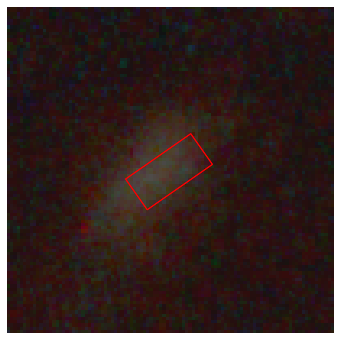

x =  [8656.08924174 8649.38332078 8629.21197537 8635.91766633]
y =  [15775.36112143 15784.8614696  15770.81654494 15761.31642173]
ra =  [101.94058357 101.9406938  101.94102544 101.94091522]
dec =  [70.2490856  70.24913838 70.24906037 70.24900759]
x =  [8656.08924174 8649.38332078 8629.21197537 8635.91766633]
y =  [15775.36112143 15784.8614696  15770.81654494 15761.31642173]
ra =  [101.94058357 101.9406938  101.94102544 101.94091522]
dec =  [70.2490856  70.24913838 70.24906037 70.24900759]


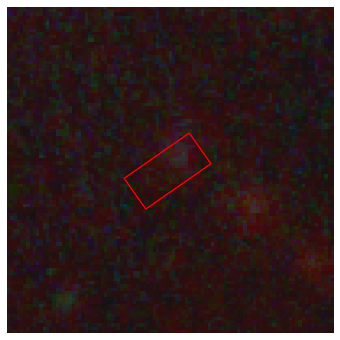

x =  [5819.28143611 5812.62139676 5792.62615959 5799.28596954]
y =  [16022.92805235 16032.40513484 16018.40911318 16008.93225635]
ra =  [101.98722294 101.98733253 101.98766113 101.98755153]
dec =  [70.25045691 70.25050954 70.25043171 70.25037909]
x =  [5819.28143611 5812.62139676 5792.62615959 5799.28596954]
y =  [16022.92805235 16032.40513484 16018.40911318 16008.93225635]
ra =  [101.98722294 101.98733253 101.98766113 101.98755153]
dec =  [70.25045691 70.25050954 70.25043171 70.25037909]


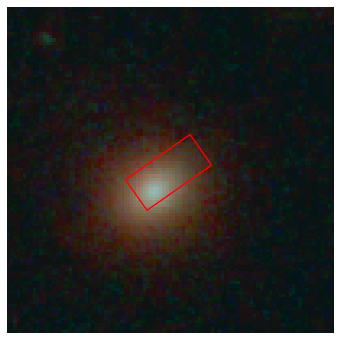

x =  [6951.57652013 6944.89890216 6924.83054425 6931.5079326 ]
y =  [16050.86232698 16060.34921916 16046.32881923 16036.84215244]
ra =  [101.96860706 101.9687169  101.96904677 101.96893693]
dec =  [70.25061517 70.25066786 70.25058994 70.25053724]
x =  [6951.57652013 6944.89890216 6924.83054425 6931.5079326 ]
y =  [16050.86232698 16060.34921916 16046.32881923 16036.84215244]
ra =  [101.96860706 101.9687169  101.96904677 101.96893693]
dec =  [70.25061517 70.25066786 70.25058994 70.25053724]


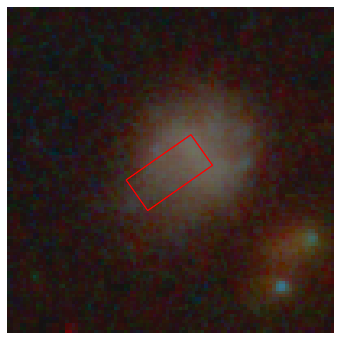

x =  [5808.54221825 5801.88298769 5781.88622056 5788.54522173]
y =  [16129.12527544 16138.6026745  16124.60280825 16115.12563487]
ra =  [101.98740062 101.98751021 101.98783884 101.98772925]
dec =  [70.25104686 70.25109949 70.25102164 70.25096901]
x =  [5808.54221825 5801.88298769 5781.88622056 5788.54522173]
y =  [16129.12527544 16138.6026745  16124.60280825 16115.12563487]
ra =  [101.98740062 101.98751021 101.98783884 101.98772925]
dec =  [70.25104686 70.25109949 70.25102164 70.25096901]


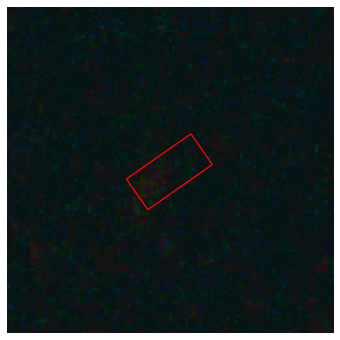

x =  [6772.13513641 6765.46241611 6745.39833614 6752.07082685]
y =  [16396.98866596 16406.47535325 16392.4454106  16382.95894874]
ra =  [101.97155945 101.97166923 101.97199905 101.97188927]
dec =  [70.25253774 70.25259043 70.25251244 70.25245975]
x =  [6772.13513641 6765.46241611 6745.39833614 6752.07082685]
y =  [16396.98866596 16406.47535325 16392.4454106  16382.95894874]
ra =  [101.97155945 101.97166923 101.97199905 101.97188927]
dec =  [70.25253774 70.25259043 70.25251244 70.25245975]
x =  [6795.64032891 6798.07635269 6774.02187448 6771.58598179]
y =  [16384.45213213 16395.83502951 16400.74579814 16389.36319334]
ra =  [101.97117289 101.9711329  101.97152845 101.97156843]
dec =  [70.25246814 70.25253138 70.25255861 70.25249537]
x =  [6769.8852377  6772.32112112 6748.26857578 6745.83282346]
y =  [16389.71043043 16401.09301455 16406.00351001 16394.62121847]
ra =  [101.9715964  101.97155642 101.97195194 101.97199192]
dec =  [70.2524973  70.25256054 70.25258777 70.25252453]
x =  [6744.1

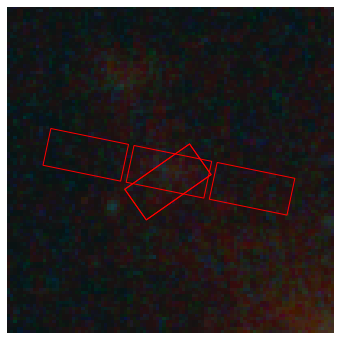

x =  [8340.5885329  8333.89161377 8313.72637655 8320.42306576]
y =  [16450.94310617 16460.44336419 16446.37913106 16436.87909806]
ra =  [101.94576991 101.94588002 101.94621161 101.9461015 ]
dec =  [70.25283898 70.25289176 70.25281363 70.25276085]
x =  [8340.5885329  8333.89161377 8313.72637655 8320.42306576]
y =  [16450.94310617 16460.44336419 16446.37913106 16436.87909806]
ra =  [101.94576991 101.94588002 101.94621161 101.9461015 ]
dec =  [70.25283898 70.25289176 70.25281363 70.25276085]


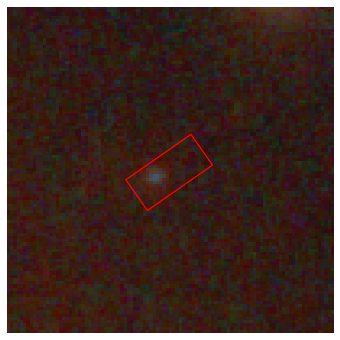

x =  [7840.09149372 7833.40254409 7813.26865152 7819.95737134]
y =  [16476.12853658 16485.62463697 16471.56972141 16462.07384617]
ra =  [101.95399956 101.95410956 101.9544406  101.9543306 ]
dec =  [70.25297882 70.25303157 70.25295348 70.25290073]
x =  [7840.09149372 7833.40254409 7813.26865152 7819.95737134]
y =  [16476.12853658 16485.62463697 16471.56972141 16462.07384617]
ra =  [101.95399956 101.95410956 101.9544406  101.9543306 ]
dec =  [70.25297882 70.25303157 70.25295348 70.25290073]


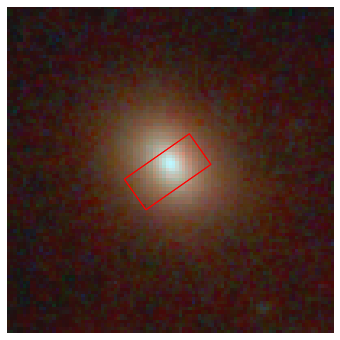

x =  [6373.51730649 6366.85150294 6346.81061443 6353.47618849]
y =  [16508.33702029 16517.82072352 16503.79472161 16494.31124392]
ra =  [101.97811468 101.97822436 101.97855378 101.9784441 ]
dec =  [70.25315537 70.25320804 70.25313006 70.2530774 ]
x =  [6373.51730649 6366.85150294 6346.81061443 6353.47618849]
y =  [16508.33702029 16517.82072352 16503.79472161 16494.31124392]
ra =  [101.97811468 101.97822436 101.97855378 101.9784441 ]
dec =  [70.25315537 70.25320804 70.25313006 70.2530774 ]
x =  [6386.60347283 6389.03741775 6365.01371282 6362.57989913]
y =  [16481.62225518 16493.00025719 16497.90631424 16486.52860474]
ra =  [101.97789929 101.97785936 101.97825442 101.97829435]
dec =  [70.25300699 70.25307021 70.2530974  70.25303418]
x =  [6360.88133093 6363.31513534 6339.29336302 6336.85968984]
y =  [16486.87550866 16498.25319748 16503.15898073 16491.78158444]
ra =  [101.97832228 101.97828235 101.97867738 101.97871731]
dec =  [70.25303611 70.25309932 70.25312651 70.2530633 ]
x =  [6335.1

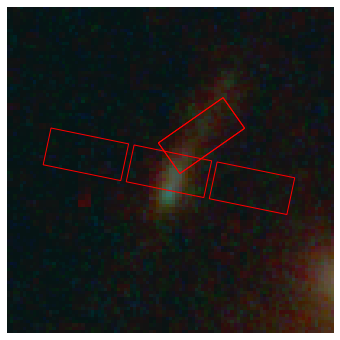

x =  [7073.08581037 7066.40964814 7046.32196696 7052.99789955]
y =  [16607.40645398 16616.89651981 16602.8523493  16593.36250883]
ra =  [101.96661208 101.9667219  101.96705215 101.96694232]
dec =  [70.2537073  70.25376001 70.25368195 70.25362924]
x =  [7073.08581037 7066.40964814 7046.32196696 7052.99789955]
y =  [16607.40645398 16616.89651981 16602.8523493  16593.36250883]
ra =  [101.96661208 101.9667219  101.96705215 101.96694232]
dec =  [70.2537073  70.25376001 70.25368195 70.25362924]


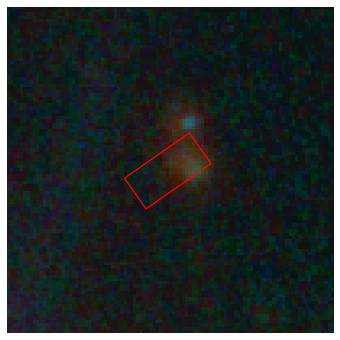

x =  [7088.60541968 7081.93025816 7061.83731613 7068.512248  ]
y =  [16813.46393072 16822.95491858 16808.90255849 16799.41179598]
ra =  [101.96635789 101.9664677  101.96679805 101.96668824]
dec =  [70.25485209 70.2549048  70.2548267  70.25477399]
x =  [7088.60541968 7081.93025816 7061.83731613 7068.512248  ]
y =  [16813.46393072 16822.95491858 16808.90255849 16799.41179598]
ra =  [101.96635789 101.9664677  101.96679805 101.96668824]
dec =  [70.25485209 70.2549048  70.2548267  70.25477399]


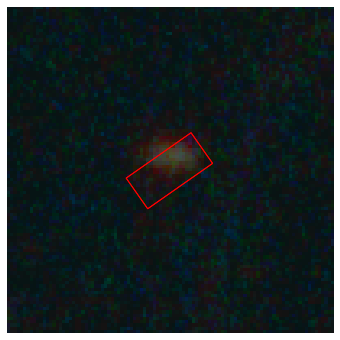

x =  [8224.00739216 8217.31494804 8197.14805792 8203.84027215]
y =  [16890.64212533 16900.14307476 16886.06445959 16876.56373521]
ra =  [101.94768678 101.94779683 101.94812847 101.94801842]
dec =  [70.25528176 70.25533455 70.25525633 70.25520355]
x =  [8224.00739216 8217.31494804 8197.14805792 8203.84027215]
y =  [16890.64212533 16900.14307476 16886.06445959 16876.56373521]
ra =  [101.94768678 101.94779683 101.94812847 101.94801842]
dec =  [70.25528176 70.25533455 70.25525633 70.25520355]


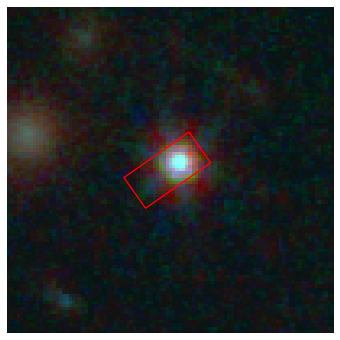

x =  [7377.60522955 7370.92637362 7350.81215543 7357.49078165]
y =  [16950.46532409 16959.95930149 16945.89577562 16936.40202349]
ra =  [101.96160593 101.9617158  101.96204653 101.96193666]
dec =  [70.25561362 70.25566636 70.2555882  70.25553547]
x =  [7377.60522955 7370.92637362 7350.81215543 7357.49078165]
y =  [16950.46532409 16959.95930149 16945.89577562 16936.40202349]
ra =  [101.96160593 101.9617158  101.96204653 101.96193666]
dec =  [70.25561362 70.25566636 70.2555882  70.25553547]


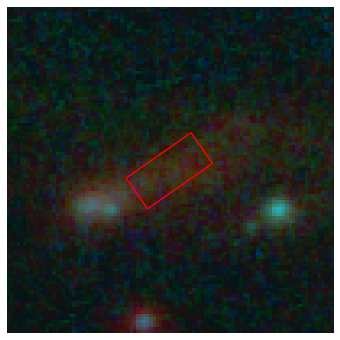

x =  [7119.50396821 7112.82943565 7092.73070632 7099.40500924]
y =  [16997.76668836 17007.25864559 16993.19861342 16983.70688152]
ra =  [101.96585065 101.96596046 101.96629093 101.96618112]
dec =  [70.25587604 70.25592876 70.25585062 70.2557979 ]
x =  [7119.50396821 7112.82943565 7092.73070632 7099.40500924]
y =  [16997.76668836 17007.25864559 16993.19861342 16983.70688152]
ra =  [101.96585065 101.96596046 101.96629093 101.96618112]
dec =  [70.25587604 70.25592876 70.25585062 70.2557979 ]
x =  [7139.18921525 7141.63458878 7117.55727416 7115.11203154]
y =  [16983.50696914 16994.89807833 16999.79455584 16988.40373932]
ra =  [101.96552686 101.96548669 101.96588268 101.96592283]
dec =  [70.25579685 70.25586014 70.2558873  70.25582402]
x =  [7113.40967273 7115.85490609 7091.77952399 7089.33442154]
y =  [16988.74996596 17000.14076179 17005.03696665 16993.64646349]
ra =  [101.96595083 101.96591067 101.96630663 101.96634678]
dec =  [70.25582594 70.25588922 70.25591639 70.2558531 ]
x =  [7087.6

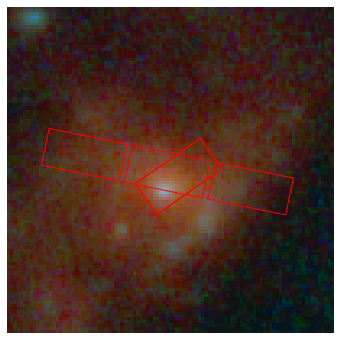

x =  [8196.90845915 8190.21888114 8170.04538735 8176.73473549]
y =  [17295.13606228 17304.63832618 17290.54484367 17281.04280483]
ra =  [101.9481324  101.94824242 101.94857421 101.94846419]
dec =  [70.25752895 70.25758174 70.25750345 70.25745066]
x =  [8196.90845915 8190.21888114 8170.04538735 8176.73473549]
y =  [17295.13606228 17304.63832618 17290.54484367 17281.04280483]
ra =  [101.9481324  101.94824242 101.94857421 101.94846419]
dec =  [70.25752895 70.25758174 70.25750345 70.25745066]


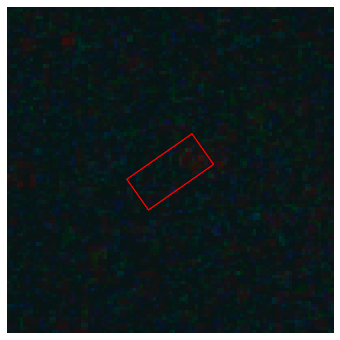

x =  [5197.03031303 5199.46567965 5175.53458492 5173.09934986]
y =  [17433.38180477 17444.74957437 17449.62387405 17438.25639686]
ra =  [101.99747209 101.99743219 101.99782586 101.99786576]
dec =  [70.25829026 70.25835343 70.2583804  70.25831723]
x =  [5171.40732983 5173.84255558 5149.91339208 5147.4782979 ]
y =  [17438.60105524 17449.96851176 17454.84253582 17443.47537169]
ra =  [101.99789359 101.99785369 101.99824733 101.99828722]
dec =  [70.25831914 70.2583823  70.25840927 70.25834611]
x =  [5145.78641442 5148.2214993  5124.29426703 5121.85931373]
y =  [17443.82001059 17455.18715403 17460.06090241 17448.69405137]
ra =  [101.99831506 101.99827516 101.99866876 101.99870866]
dec =  [70.25834802 70.25841118 70.25843815 70.25837499]


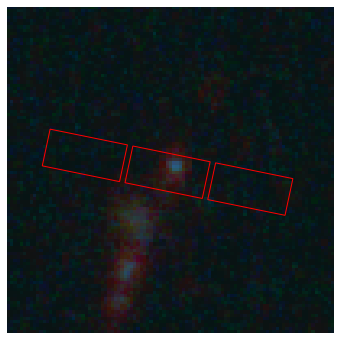

x =  [5089.30040029 5082.65214616 5062.67133212 5069.31946194]
y =  [17472.14715061 17481.63000009 17467.58910494 17458.10655674]
ra =  [101.99924449 101.99935396 101.9996824  101.99957293]
dec =  [70.25850513 70.25855778 70.25847968 70.25842703]
x =  [5089.30040029 5082.65214616 5062.67133212 5069.31946194]
y =  [17472.14715061 17481.63000009 17467.58910494 17458.10655674]
ra =  [101.99924449 101.99935396 101.9996824  101.99957293]
dec =  [70.25850513 70.25855778 70.25847968 70.25842703]


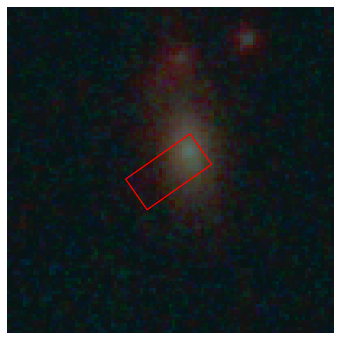

x =  [4525.76855148 4519.12337085 4499.17097759 4505.81603401]
y =  [17547.65433005 17557.13776932 17543.10661461 17533.62347671]
ra =  [102.00851435 102.0086238  102.00895174 102.00884229]
dec =  [70.25892175 70.2589744  70.25889634 70.25884369]
x =  [4525.76855148 4519.12337085 4499.17097759 4505.81603401]
y =  [17547.65433005 17557.13776932 17543.10661461 17533.62347671]
ra =  [102.00851435 102.0086238  102.00895174 102.00884229]
dec =  [70.25892175 70.2589744  70.25889634 70.25884369]


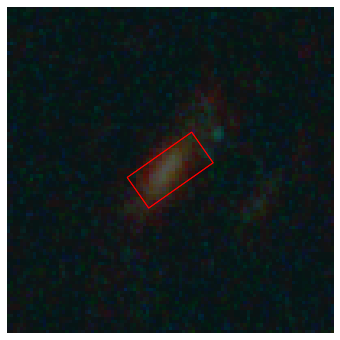

x =  [10246.23942083 10239.5219317  10219.18964511 10225.90686677]
y =  [17964.32521652 17973.85651692 17959.67683165 17950.14585866]
ra =  [101.91442172 101.91453213 101.91486672 101.91475631]
dec =  [70.2612435  70.26129647 70.26121776 70.26116479]
x =  [10246.23942083 10239.5219317  10219.18964511 10225.90686677]
y =  [17964.32521652 17973.85651692 17959.67683165 17950.14585866]
ra =  [101.91442172 101.91453213 101.91486672 101.91475631]
dec =  [70.2612435  70.26129647 70.26121776 70.26116479]


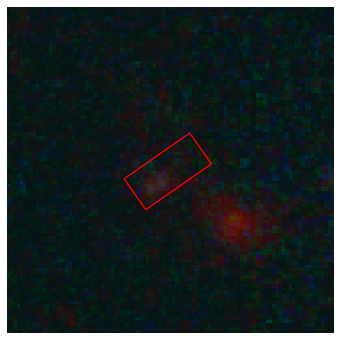

x =  [10171.83343832 10165.11736563 10144.79007922 10151.50588446]
y =  [17977.76299552 17987.29363185 17973.11487535 17963.58456644]
ra =  [101.91564555 101.91575594 101.91609044 101.91598005]
dec =  [70.26131838 70.26137135 70.26129263 70.26123967]
x =  [10171.83343832 10165.11736563 10144.79007922 10151.50588446]
y =  [17977.76299552 17987.29363185 17973.11487535 17963.58456644]
ra =  [101.91564555 101.91575594 101.91609044 101.91598005]
dec =  [70.26131838 70.26137135 70.26129263 70.26123967]


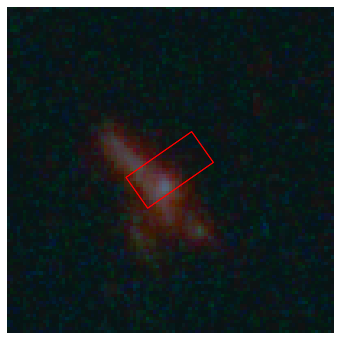

x =  [4867.84213595 4861.19461759 4841.21236023 4847.85975428]
y =  [18016.11282475 18025.60581597 18011.54385346 18002.05116353]
ra =  [102.00289493 102.00300442 102.00333292 102.00322343]
dec =  [70.26152609 70.2615788  70.26150058 70.26144787]
x =  [4867.84213595 4861.19461759 4841.21236023 4847.85975428]
y =  [18016.11282475 18025.60581597 18011.54385346 18002.05116353]
ra =  [102.00289493 102.00300442 102.00333292 102.00322343]
dec =  [70.26152609 70.2615788  70.26150058 70.26144787]


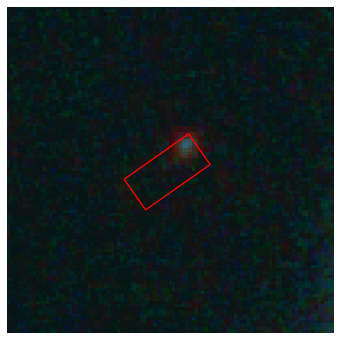

x =  [5132.35092906 5125.7017804  5105.70118128 5112.35020556]
y =  [18185.9755425  18195.47220608 18181.3957497  18171.89938735]
ra =  [101.99854612 101.99865563 101.99898446 101.99887495]
dec =  [70.26247104 70.26252377 70.26244547 70.26239275]
x =  [5132.35092906 5125.7017804  5105.70118128 5112.35020556]
y =  [18185.9755425  18195.47220608 18181.3957497  18171.89938735]
ra =  [101.99854612 101.99865563 101.99898446 101.99887495]
dec =  [70.26247104 70.26252377 70.26244547 70.26239275]


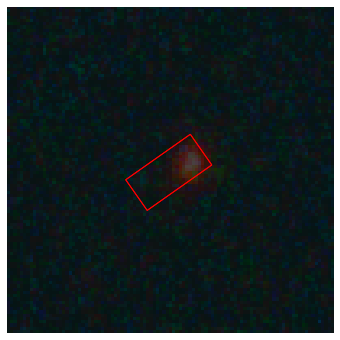

x =  [3825.16970116 3818.52776489 3798.59517675 3805.23698891]
y =  [18275.19342412 18284.68980194 18270.64009008 18261.1440137 ]
ra =  [102.02005172 102.02016117 102.02048881 102.02037936]
dec =  [70.26295941 70.26301212 70.26293394 70.26288123]
x =  [3825.16970116 3818.52776489 3798.59517675 3805.23698891]
y =  [18275.19342412 18284.68980194 18270.64009008 18261.1440137 ]
ra =  [102.02005172 102.02016117 102.02048881 102.02037936]
dec =  [70.26295941 70.26301212 70.26293394 70.26288123]


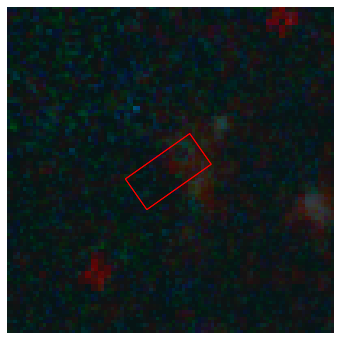

x =  [3851.04786983 3844.40569822 3824.4692707  3831.11131819]
y =  [18374.89121371 18384.38955136 18370.33440148 18360.83636524]
ra =  [102.01962792 102.01973738 102.02006509 102.01995563]
dec =  [70.26351345 70.26356618 70.26348797 70.26343524]
x =  [3851.04786983 3844.40569822 3824.4692707  3831.11131819]
y =  [18374.89121371 18384.38955136 18370.33440148 18360.83636524]
ra =  [102.01962792 102.01973738 102.02006509 102.01995563]
dec =  [70.26351345 70.26356618 70.26348797 70.26343524]


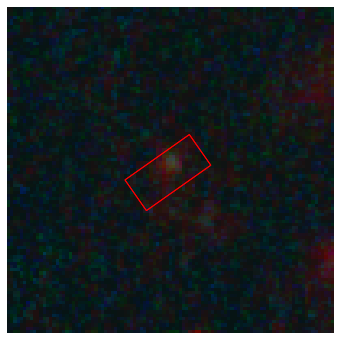

x =  [5406.43380526 5399.78281899 5379.7592506  5386.41011243]
y =  [18525.55922689 18535.06283568 18520.96347208 18511.46016446]
ra =  [101.9940415  101.99415104 101.9944803  101.99437076]
dec =  [70.26435882 70.26441159 70.26433317 70.2642804 ]
x =  [5406.43380526 5399.78281899 5379.7592506  5386.41011243]
y =  [18525.55922689 18535.06283568 18520.96347208 18511.46016446]
ra =  [101.9940415  101.99415104 101.9944803  101.99437076]
dec =  [70.26435882 70.26441159 70.26433317 70.2642804 ]


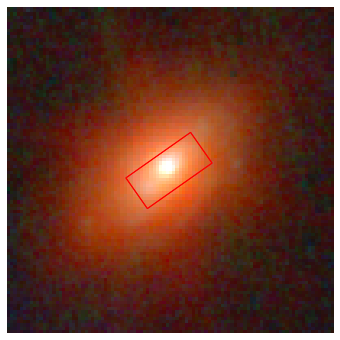

x =  [10197.23240131 10190.52212527 10170.17246427 10176.88247286]
y =  [18910.55814891 18920.09666501 18905.87128894 18896.33310023]
ra =  [101.91521942 101.91532975 101.9156647  101.91555438]
dec =  [70.26650049 70.26655351 70.26647454 70.26642153]
x =  [10197.23240131 10190.52212527 10170.17246427 10176.88247286]
y =  [18910.55814891 18920.09666501 18905.87128894 18896.33310023]
ra =  [101.91521942 101.91532975 101.9156647  101.91555438]
dec =  [70.26650049 70.26655351 70.26647454 70.26642153]


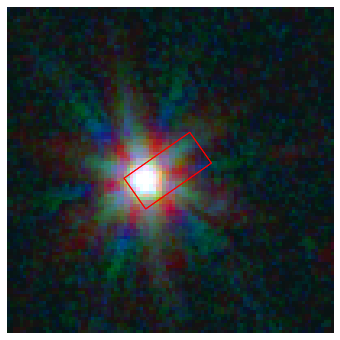

x =  [10070.20959125 10063.5018612  10043.16031103 10049.86777367]
y =  [18952.53341178 18962.07095005 18947.84621521 18938.30900438]
ra =  [101.91730908 101.91741937 101.91775419 101.9176439 ]
dec =  [70.26673406 70.26678707 70.2667081  70.26665509]
x =  [10070.20959125 10063.5018612  10043.16031103 10049.86777367]
y =  [18952.53341178 18962.07095005 18947.84621521 18938.30900438]
ra =  [101.91730908 101.91741937 101.91775419 101.9176439 ]
dec =  [70.26673406 70.26678707 70.2667081  70.26665509]


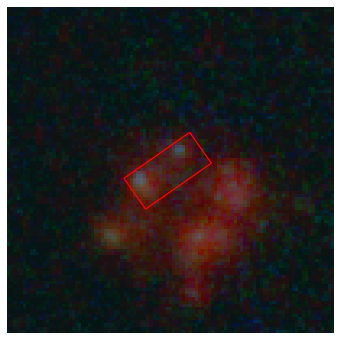

x =  [7883.45108793 7876.73509682 7856.68994043 7863.40570163]
y =  [12100.80186642 12110.28144979 12096.39324545 12086.91388728]
ra =  [101.95328064 101.95339096 101.95372015 101.95360984]
dec =  [70.22867147 70.22872413 70.22864697 70.22859431]
x =  [7883.45108793 7876.73509682 7856.68994043 7863.40570163]
y =  [12100.80186642 12110.28144979 12096.39324545 12086.91388728]
ra =  [101.95328064 101.95339096 101.95372015 101.95360984]
dec =  [70.22867147 70.22872413 70.22864697 70.22859431]


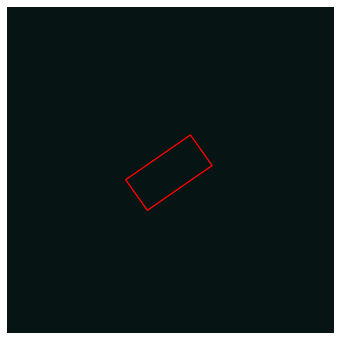

x =  [7494.92924091 7488.21936775 7468.19898263 7474.90862596]
y =  [12107.52879414 12117.00508305 12103.12467089 12093.64860728]
ra =  [101.95966158 101.95977181 101.96010057 101.95999035]
dec =  [70.22870855 70.22876119 70.22868406 70.22863142]
x =  [7494.92924091 7488.21936775 7468.19898263 7474.90862596]
y =  [12107.52879414 12117.00508305 12103.12467089 12093.64860728]
ra =  [101.95966158 101.95977181 101.96010057 101.95999035]
dec =  [70.22870855 70.22876119 70.22868406 70.22863142]


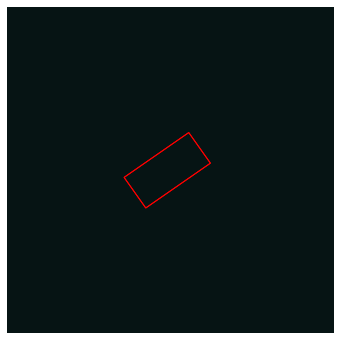

x =  [8679.74618195 8673.02870692 8652.89440838 8659.61165337]
y =  [13920.53677676 13930.03019225 13916.05571172 13906.56252122]
ra =  [101.94019868 101.94030904 101.94063991 101.94052955]
dec =  [70.238781   70.23883375 70.23875613 70.23870338]
x =  [8679.74618195 8673.02870692 8652.89440838 8659.61165337]
y =  [13920.53677676 13930.03019225 13916.05571172 13906.56252122]
ra =  [101.94019868 101.94030904 101.94063991 101.94052955]
dec =  [70.238781   70.23883375 70.23875613 70.23870338]


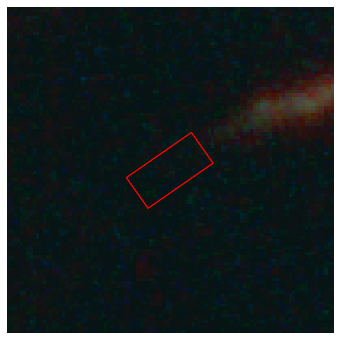

x =  [8290.04983812 8283.33848299 8263.22892366 8269.94004883]
y =  [13926.42552299 13935.91564776 13921.94898197 13912.45908227]
ra =  [101.94660203 101.9467123  101.94704274 101.94693247]
dec =  [70.23881389 70.23886661 70.23878902 70.2387363 ]
x =  [8290.04983812 8283.33848299 8263.22892366 8269.94004883]
y =  [13926.42552299 13935.91564776 13921.94898197 13912.45908227]
ra =  [101.94660203 101.9467123  101.94704274 101.94693247]
dec =  [70.23881389 70.23886661 70.23878902 70.2387363 ]


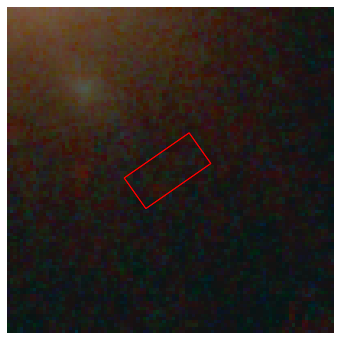

x =  [9477.10749816 9470.38121861 9450.18363376 9456.90968311]
y =  [14522.66533368 14532.16782809 14518.15387626 14508.65160661]
ra =  [101.92709329 101.92720378 101.92753579 101.9274253 ]
dec =  [70.2421251  70.2421779  70.24210009 70.24204728]
x =  [9477.10749816 9470.38121861 9450.18363376 9456.90968311]
y =  [14522.66533368 14532.16782809 14518.15387626 14508.65160661]
ra =  [101.92709329 101.92720378 101.92753579 101.9274253 ]
dec =  [70.2421251  70.2421779  70.24210009 70.24204728]


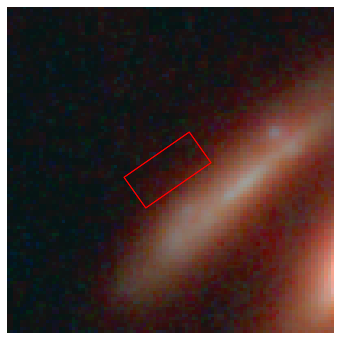

x =  [8674.60882784 8667.89503904 8647.74859247 8654.46215123]
y =  [14518.83206133 14528.3277393  14514.33046326 14504.83501025]
ra =  [101.94028181 101.94039213 101.94072325 101.94061294]
dec =  [70.24210487 70.24215763 70.24207988 70.24202712]
x =  [8674.60882784 8667.89503904 8647.74859247 8654.46215123]
y =  [14518.83206133 14528.3277393  14514.33046326 14504.83501025]
ra =  [101.94028181 101.94039213 101.94072325 101.94061294]
dec =  [70.24210487 70.24215763 70.24207988 70.24202712]


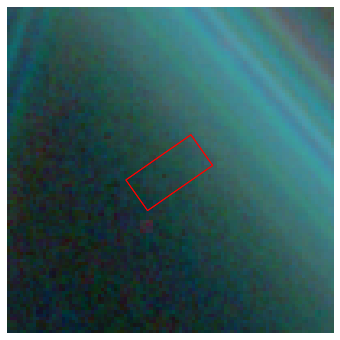

x =  [7485.08750554 7478.39231471 7458.32175648 7465.01671752]
y =  [14520.89876444 14530.38432287 14516.41149048 14506.92615733]
ra =  [101.95983077 101.95994083 101.96027063 101.96016057]
dec =  [70.24211615 70.24216884 70.24209119 70.24203851]
x =  [7485.08750554 7478.39231471 7458.32175648 7465.01671752]
y =  [14520.89876444 14530.38432287 14516.41149048 14506.92615733]
ra =  [101.95983077 101.95994083 101.96027063 101.96016057]
dec =  [70.24211615 70.24216884 70.24209119 70.24203851]


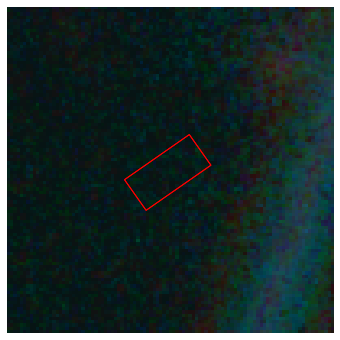

x =  [6687.20352102 6680.52080086 6660.50141339 6667.18390395]
y =  [14517.50313125 14526.98185271 14513.0256143  14503.54711831]
ra =  [101.97294341 101.9730533  101.97338221 101.97327233]
dec =  [70.24209597 70.24214861 70.24207103 70.24201839]
x =  [6687.20352102 6680.52080086 6660.50141339 6667.18390395]
y =  [14517.50313125 14526.98185271 14513.0256143  14503.54711831]
ra =  [101.97294341 101.9730533  101.97338221 101.97327233]
dec =  [70.24209597 70.24214861 70.24207103 70.24201839]


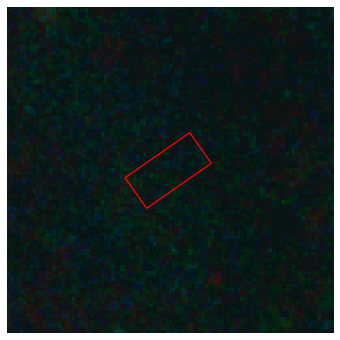

x =  [12253.35332913 12246.58115887 12226.16919166 12232.94109386]
y =  [15128.41580184 15137.94466287 15123.86232219 15114.333788  ]
ra =  [101.8814567  101.88156784 101.8819036  101.88179247]
dec =  [70.24547924 70.24553222 70.24545411 70.24540113]
x =  [12253.35332913 12246.58115887 12226.16919166 12232.94109386]
y =  [15128.41580184 15137.94466287 15123.86232219 15114.333788  ]
ra =  [101.8814567  101.88156784 101.8819036  101.88179247]
dec =  [70.24547924 70.24553222 70.24545411 70.24540113]


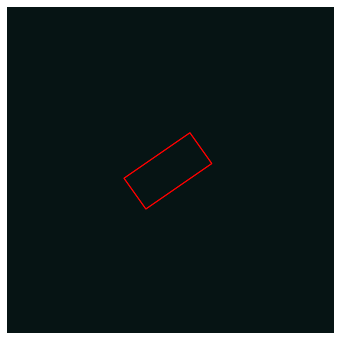

x =  [9885.34614502 9878.61718114 9858.38107682 9865.10981043]
y =  [15131.66072602 15141.1690081  15127.12339233 15117.6153349 ]
ra =  [101.92037959 101.92049012 101.92082285 101.92071232]
dec =  [70.24550749 70.24556033 70.24548235 70.24542951]
x =  [9885.34614502 9878.61718114 9858.38107682 9865.10981043]
y =  [15131.66072602 15141.1690081  15127.12339233 15117.6153349 ]
ra =  [101.92037959 101.92049012 101.92082285 101.92071232]
dec =  [70.24550749 70.24556033 70.24548235 70.24542951]


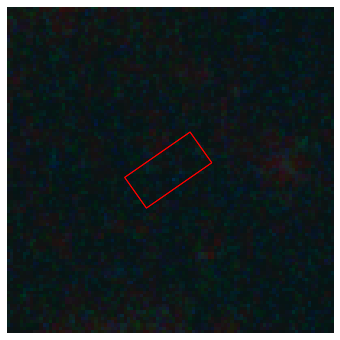

x =  [5099.79522969 5093.14472445 5073.20186356 5079.85213956]
y =  [15730.23801298 15739.70777525 15725.7377954  15716.26825899]
ra =  [101.99904797 101.99915743 101.99948509 101.99937563]
dec =  [70.24882791 70.24888049 70.24880279 70.24875021]
x =  [5099.79522969 5093.14472445 5073.20186356 5079.85213956]
y =  [15730.23801298 15739.70777525 15725.7377954  15716.26825899]
ra =  [101.99904797 101.99915743 101.99948509 101.99937563]
dec =  [70.24882791 70.24888049 70.24880279 70.24875021]


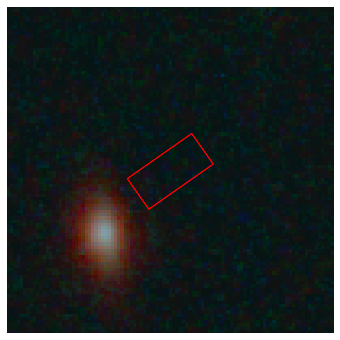

x =  [13843.63410577 13836.84187317 13816.29066082 13823.08262496]
y =  [16339.81018749 16349.36534372 16335.18887451 16325.63404466]
ra =  [101.8552869  101.85539834 101.85573661 101.85562517]
dec =  [70.25219761 70.25225075 70.25217217 70.25211903]
x =  [13843.63410577 13836.84187317 13816.29066082 13823.08262496]
y =  [16339.81018749 16349.36534372 16335.18887451 16325.63404466]
ra =  [101.8552869  101.85539834 101.85573661 101.85562517]
dec =  [70.25219761 70.25225075 70.25217217 70.25211903]


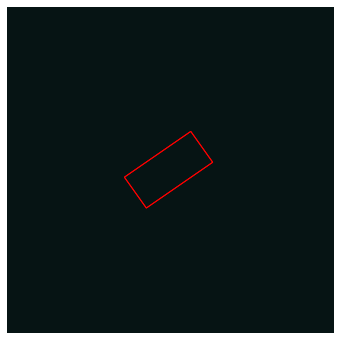

x =  [12663.44175007 12656.67042993 12636.20246562 12642.97351762]
y =  [16342.41330534 16351.95635801 16337.80506765 16328.2623417 ]
ra =  [101.87469198 101.87480313 101.87513995 101.87502881]
dec =  [70.25222104 70.2522741  70.25219562 70.25214256]
x =  [12663.44175007 12656.67042993 12636.20246562 12642.97351762]
y =  [16342.41330534 16351.95635801 16337.80506765 16328.2623417 ]
ra =  [101.87469198 101.87480313 101.87513995 101.87502881]
dec =  [70.25222104 70.2522741  70.25219562 70.25214256]


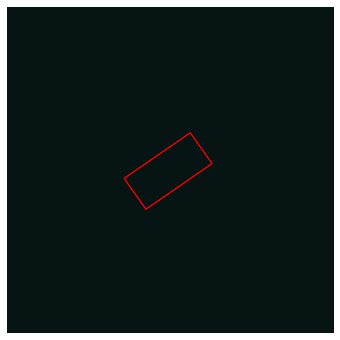

x =  [12268.43371129 12261.6694279  12241.22932214 12247.99333749]
y =  [16346.99515954 16356.53417636 16342.39113622 16332.85244624]
ra =  [101.88118676 101.88129781 101.88163415 101.88152311]
dec =  [70.25224903 70.25230206 70.25222362 70.25217058]
x =  [12268.43371129 12261.6694279  12241.22932214 12247.99333749]
y =  [16346.99515954 16356.53417636 16342.39113622 16332.85244624]
ra =  [101.88118676 101.88129781 101.88163415 101.88152311]
dec =  [70.25224903 70.25230206 70.25222362 70.25217058]


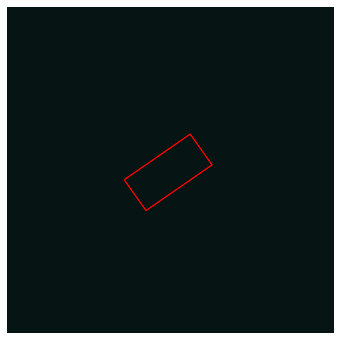

x =  [7095.96947023 7089.2913779  7069.20763957 7075.88550225]
y =  [16346.89303092 16356.38229311 16342.34760648 16332.85856964]
ra =  [101.96623452 101.96634437 101.96667453 101.96656468]
dec =  [70.25226004 70.25231275 70.25223474 70.25218204]
x =  [7095.96947023 7089.2913779  7069.20763957 7075.88550225]
y =  [16346.89303092 16356.38229311 16342.34760648 16332.85856964]
ra =  [101.96623452 101.96634437 101.96667453 101.96656468]
dec =  [70.25226004 70.25231275 70.25223474 70.25218204]
x =  [7104.86285493 7107.30056228 7083.22288829 7080.78531192]
y =  [16321.32975349 16332.71641034 16337.63045395 16326.24408972]
ra =  [101.96608817 101.96604814 101.96644406 101.96648408]
dec =  [70.25211804 70.2521813  70.25220856 70.2521453 ]
x =  [7079.08292772 7081.52049483 7057.44475391 7055.0073178 ]
y =  [16326.5915584  16337.97790194 16342.89167285 16331.50562193]
ra =  [101.96651208 101.96647205 101.96686794 101.96690796]
dec =  [70.25214723 70.25221049 70.25223774 70.25217448]
x =  [7053.3

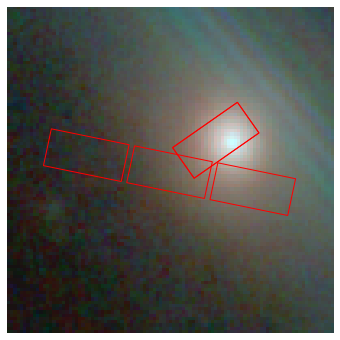

x =  [6298.39985027 6291.73422068 6271.70160532 6278.36700542]
y =  [16341.98627145 16351.46869214 16337.4505973  16327.96840216]
ra =  [101.97934845 101.97945812 101.97978739 101.97967771]
dec =  [70.25223099 70.25228365 70.25220572 70.25215306]
x =  [6298.39985027 6291.73422068 6271.70160532 6278.36700542]
y =  [16341.98627145 16351.46869214 16337.4505973  16327.96840216]
ra =  [101.97934845 101.97945812 101.97978739 101.97967771]
dec =  [70.25223099 70.25228365 70.25220572 70.25215306]


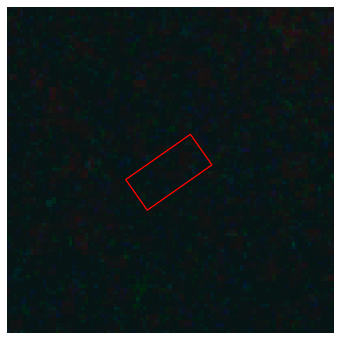

x =  [15048.11863678 15041.30927365 15020.65992155 15027.46901592]
y =  [16957.42369773 16966.99618926 16952.76347944 16943.19131392]
ra =  [101.83546356 101.83557525 101.83591526 101.83580358]
dec =  [70.25561748 70.25567074 70.25559188 70.25553863]
x =  [15048.11863678 15041.30927365 15020.65992155 15027.46901592]
y =  [16957.42369773 16966.99618926 16952.76347944 16943.19131392]
ra =  [101.83546356 101.83557525 101.83591526 101.83580358]
dec =  [70.25561748 70.25567074 70.25559188 70.25553863]


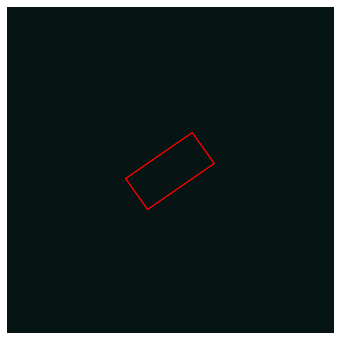

x =  [11455.03215253 11448.28630724 11427.89068284 11434.63626033]
y =  [16943.1941559  16952.72964575 16938.57455879 16929.03939601]
ra =  [101.89455239 101.89466319 101.8949988  101.894888  ]
dec =  [70.25556572 70.25561873 70.25554019 70.25548719]
x =  [11455.03215253 11448.28630724 11427.89068284 11434.63626033]
y =  [16943.1941559  16952.72964575 16938.57455879 16929.03939601]
ra =  [101.89455239 101.89466319 101.8949988  101.894888  ]
dec =  [70.25556572 70.25561873 70.25554019 70.25548719]


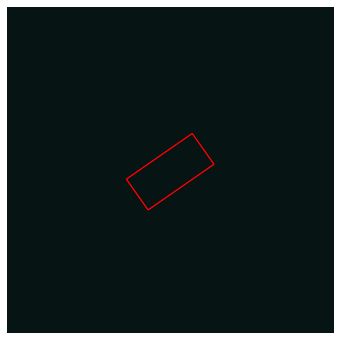

x =  [15444.92462681 15438.11230128 15417.42210533 15424.23416201]
y =  [17558.98250596 17568.56391999 17554.29313125 17544.71204311]
ra =  [101.82891868 101.82903042 101.82937118 101.82925945]
dec =  [70.25895527 70.25900857 70.25892952 70.25887621]
x =  [15444.92462681 15438.11230128 15417.42210533 15424.23416201]
y =  [17558.98250596 17568.56391999 17554.29313125 17544.71204311]
ra =  [101.82891868 101.82903042 101.82937118 101.82925945]
dec =  [70.25895527 70.25900857 70.25892952 70.25887621]


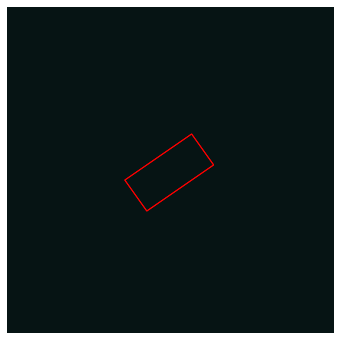

x =  [12263.08165898 12256.3255465  12235.8592297  12242.61507417]
y =  [17552.98511356 17562.53393384 17548.33140483 17538.78291136]
ra =  [101.88125295 101.8813639  101.88170078 101.88158983]
dec =  [70.258949   70.25900209 70.25892331 70.25887022]
x =  [12263.08165898 12256.3255465  12235.8592297  12242.61507417]
y =  [17552.98511356 17562.53393384 17548.33140483 17538.78291136]
ra =  [101.88125295 101.8813639  101.88170078 101.88158983]
dec =  [70.258949   70.25900209 70.25892331 70.25887022]


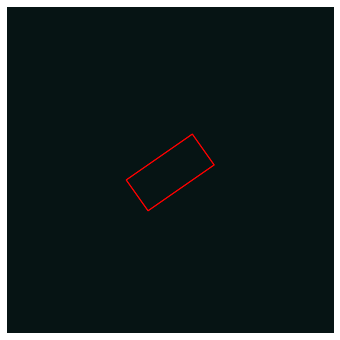

x =  [11868.39168973 11861.64261054 11841.20413529 11847.95294657]
y =  [17557.02123161 17566.56601347 17552.37173036 17542.82727543]
ra =  [101.88774464 101.8878555  101.88819189 101.88808105]
dec =  [70.25897372 70.25902678 70.25894804 70.25889498]
x =  [11868.39168973 11861.64261054 11841.20413529 11847.95294657]
y =  [17557.02123161 17566.56601347 17552.37173036 17542.82727543]
ra =  [101.88774464 101.8878555  101.88819189 101.88808105]
dec =  [70.25897372 70.25902678 70.25894804 70.25889498]


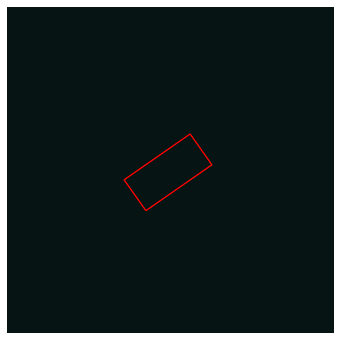

x =  [7887.74780988 7881.06460826 7860.90550695 7867.58847876]
y =  [17551.34790986 17560.84852502 17546.75161427 17537.25122425]
ra =  [101.9532174  101.95332733 101.95365888 101.95354895]
dec =  [70.25895228 70.25900506 70.25892674 70.25887396]
x =  [7887.74780988 7881.06460826 7860.90550695 7867.58847876]
y =  [17551.34790986 17560.84852502 17546.75161427 17537.25122425]
ra =  [101.9532174  101.95332733 101.95365888 101.95354895]
dec =  [70.25895228 70.25900506 70.25892674 70.25887396]


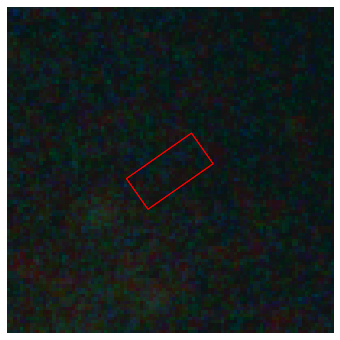

x =  [3914.09434875 3907.4525737  3887.53287478 3894.17452573]
y =  [17556.52424357 17566.00690601 17551.98987844 17542.50751747]
ra =  [102.01857516 102.01868459 102.01901195 102.01890253]
dec =  [70.25896738 70.25902002 70.25894202 70.25888939]
x =  [3914.09434875 3907.4525737  3887.53287478 3894.17452573]
y =  [17556.52424357 17566.00690601 17551.98987844 17542.50751747]
ra =  [102.01857516 102.01868459 102.01901195 102.01890253]
dec =  [70.25896738 70.25902002 70.25894202 70.25888939]


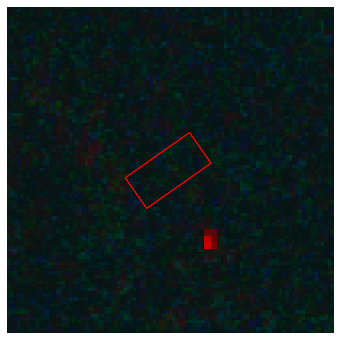

x =  [3507.26630311 3500.62680891 3480.72927421 3487.3686444 ]
y =  [17546.69029979 17556.17213718 17542.16527723 17532.68374136]
ra =  [102.02526637 102.02537577 102.02570275 102.02559335]
dec =  [70.25891002 70.25896265 70.25888469 70.25883206]
x =  [3507.26630311 3500.62680891 3480.72927421 3487.3686444 ]
y =  [17546.69029979 17556.17213718 17542.16527723 17532.68374136]
ra =  [102.02526637 102.02537577 102.02570275 102.02559335]
dec =  [70.25891002 70.25896265 70.25888469 70.25883206]


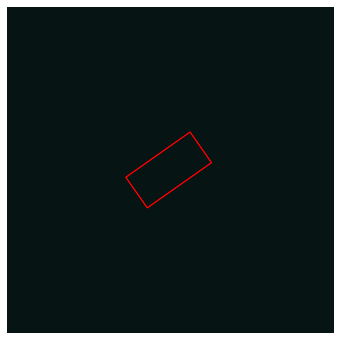

x =  [12260.93959205 12254.18756388 12233.70815679 12240.45991695]
y =  [18156.91368788 18166.46740903 18152.23513251 18142.68173818]
ra =  [101.88127726 101.88138816 101.88172531 101.88161441]
dec =  [70.26230417 70.26235729 70.26227834 70.26222523]
x =  [12260.93959205 12254.18756388 12233.70815679 12240.45991695]
y =  [18156.91368788 18166.46740903 18152.23513251 18142.68173818]
ra =  [101.88127726 101.88138816 101.88172531 101.88161441]
dec =  [70.26230417 70.26235729 70.26227834 70.26222523]


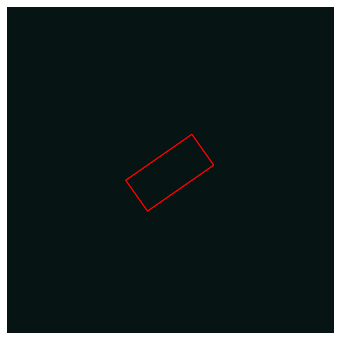

x =  [11056.25083462 11049.5201844  11029.12616551 11035.85654805]
y =  [18153.0317834  18162.57303173 18148.36669117 18138.82577001]
ra =  [101.90109496 101.90120556 101.90154123 101.90143064]
dec =  [70.26228887 70.26234191 70.26226307 70.26221004]
x =  [11056.25083462 11049.5201844  11029.12616551 11035.85654805]
y =  [18153.0317834  18162.57303173 18148.36669117 18138.82577001]
ra =  [101.90109496 101.90120556 101.90154123 101.90143064]
dec =  [70.26228887 70.26234191 70.26226307 70.26221004]


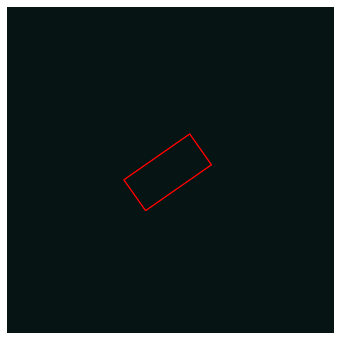

x =  [2723.98133712 2717.34565278 2697.47507772 2704.11063818]
y =  [18166.4568645  18175.94942842 18161.93120235 18152.43894004]
ra =  [102.03816467 102.03827406 102.0386006  102.03849121]
dec =  [70.26234719 70.26239987 70.26232183 70.26226915]
x =  [2723.98133712 2717.34565278 2697.47507772 2704.11063818]
y =  [18166.4568645  18175.94942842 18161.93120235 18152.43894004]
ra =  [102.03816467 102.03827406 102.0386006  102.03849121]
dec =  [70.26234719 70.26239987 70.26232183 70.26226915]


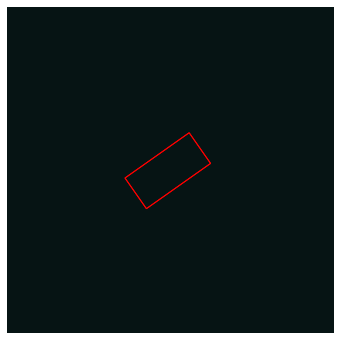

x =  [14653.06588991 14646.27562857 14625.61471041 14632.40470313]
y =  [18767.5977805  18777.18094512 18762.86763203 18753.28479351]
ra =  [101.84190824 101.84201969 101.84236003 101.84224859]
dec =  [70.26567794 70.26573124 70.26565192 70.26559862]
x =  [14653.06588991 14646.27562857 14625.61471041 14632.40470313]
y =  [18767.5977805  18777.18094512 18762.86763203 18753.28479351]
ra =  [101.84190824 101.84201969 101.84236003 101.84224859]
dec =  [70.26567794 70.26573124 70.26565192 70.26559862]


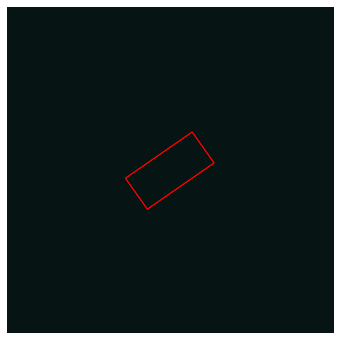

x =  [12654.51489625 12647.75991724 12627.23961191 12633.99432283]
y =  [18758.02874185 18767.59139969 18753.32111429 18743.75878315]
ra =  [101.87479084 101.8749018  101.8752397  101.87512875]
dec =  [70.26564117 70.26569434 70.2656152  70.26556203]
x =  [12654.51489625 12647.75991724 12627.23961191 12633.99432283]
y =  [18758.02874185 18767.59139969 18753.32111429 18743.75878315]
ra =  [101.87479084 101.8749018  101.8752397  101.87512875]
dec =  [70.26564117 70.26569434 70.2656152  70.26556203]


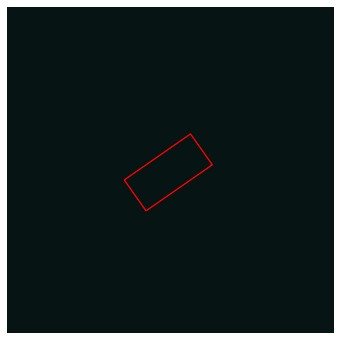

x =  [12653.1722465  12646.42135088 12625.88798574 12632.63861328]
y =  [19363.48870343 19373.05626109 19358.7562218  19349.18899081]
ra =  [101.87480092 101.87491182 101.87525    101.8751391 ]
dec =  [70.26900484 70.26905804 70.26897873 70.26892554]
x =  [12653.1722465  12646.42135088 12625.88798574 12632.63861328]
y =  [19363.48870343 19373.05626109 19358.7562218  19349.18899081]
ra =  [101.87480092 101.87491182 101.87525    101.8751391 ]
dec =  [70.26900484 70.26905804 70.26897873 70.26892554]


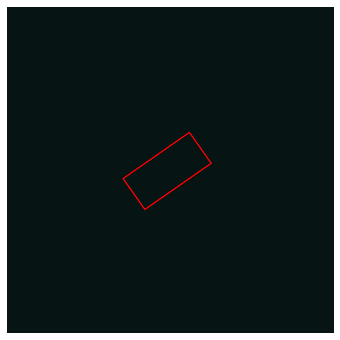

x =  [5906.95396234 5900.29942349 5880.22864226 5886.88305651]
y =  [19367.65759982 19377.17812135 19363.02629896 19353.50607849]
ra =  [101.98581545 101.98592506 101.98625519 101.98614559]
dec =  [70.26903904 70.26909191 70.26901322 70.26896035]
x =  [5906.95396234 5900.29942349 5880.22864226 5886.88305651]
y =  [19367.65759982 19377.17812135 19363.02629896 19353.50607849]
ra =  [101.98581545 101.98592506 101.98625519 101.98614559]
dec =  [70.26903904 70.26909191 70.26901322 70.26896035]


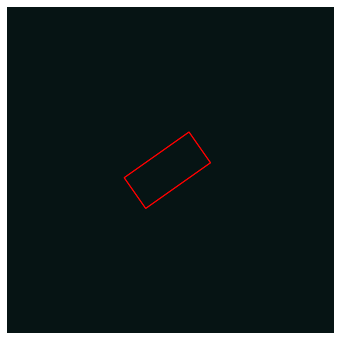

x =  [2713.35277605 2706.71606456 2686.81655573 2693.45314327]
y =  [19365.55618107 19375.07181507 19360.99585431 19351.48052186]
ra =  [102.03836871 102.03847816 102.03880527 102.03869583]
dec =  [70.26900876 70.26906157 70.2689832  70.26893039]
x =  [2713.35277605 2706.71606456 2686.81655573 2693.45314327]
y =  [19365.55618107 19375.07181507 19360.99585431 19351.48052186]
ra =  [102.03836871 102.03847816 102.03880527 102.03869583]
dec =  [70.26900876 70.26906157 70.2689832  70.26893039]


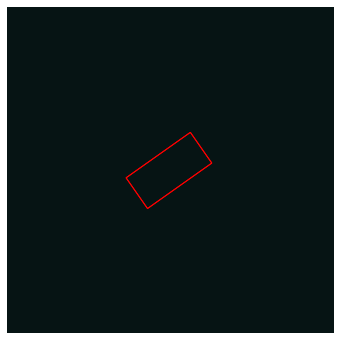

x =  [2328.18910198 2321.55454013 2301.67566126 2308.31009924]
y =  [19370.60716202 19380.12229268 19366.05525454 19356.54042548]
ra =  [102.04470701 102.04481644 102.04514319 102.04503377]
dec =  [70.26903354 70.26908634 70.26900801 70.26895521]
x =  [2328.18910198 2321.55454013 2301.67566126 2308.31009924]
y =  [19370.60716202 19380.12229268 19366.05525454 19356.54042548]
ra =  [102.04470701 102.04481644 102.04514319 102.04503377]
dec =  [70.26903354 70.26908634 70.26900801 70.26895521]


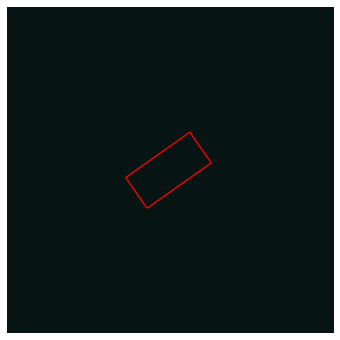

x =  [12652.18487395 12645.43806096 12624.89164622 12631.63819114]
y =  [19969.57111371 19979.14357063 19964.81377536 19955.24164512]
ra =  [101.87480514 101.87491599 101.87525444 101.87514359]
dec =  [70.27237197 70.27242519 70.27234572 70.2722925 ]
x =  [12652.18487395 12645.43806096 12624.89164622 12631.63819114]
y =  [19969.57111371 19979.14357063 19964.81377536 19955.24164512]
ra =  [101.87480514 101.87491599 101.87525444 101.87514359]
dec =  [70.27237197 70.27242519 70.27234572 70.2722925 ]


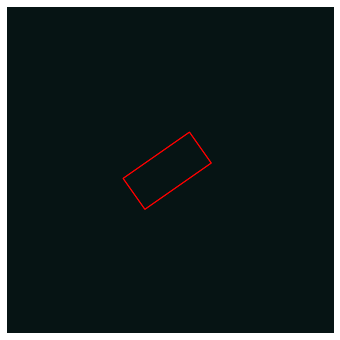

x =  [11861.60394521 11854.87119639 11834.38038051 11841.11286146]
y =  [19975.32383478 19984.88821598 19970.57493959 19961.0108853 ]
ra =  [101.88781681 101.88792747 101.88826495 101.8881543 ]
dec =  [70.27240876 70.27246193 70.27238252 70.27232935]
x =  [11861.60394521 11854.87119639 11834.38038051 11841.11286146]
y =  [19975.32383478 19984.88821598 19970.57493959 19961.0108853 ]
ra =  [101.88781681 101.88792747 101.88826495 101.8881543 ]
dec =  [70.27240876 70.27246193 70.27238252 70.27232935]


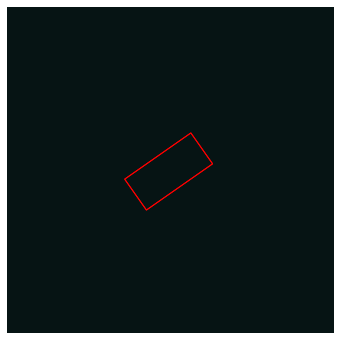

x =  [5903.53427322 5896.87921177 5876.79405004 5883.44898685]
y =  [19969.8093292  19979.34138098 19965.16066554 19955.62891478]
ra =  [101.98587785 101.98598748 101.98631791 101.98620828]
dec =  [70.27238432 70.27243725 70.2723584  70.27230547]
x =  [5903.53427322 5896.87921177 5876.79405004 5883.44898685]
y =  [19969.8093292  19979.34138098 19965.16066554 19955.62891478]
ra =  [101.98587785 101.98598748 101.98631791 101.98620828]
dec =  [70.27238432 70.27243725 70.2723584  70.27230547]


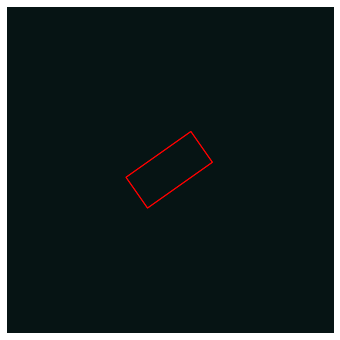

x =  [4711.65408951 4705.00566642 4684.98395848 4691.63225718]
y =  [19977.99982323 19987.53026181 19973.37734805 19963.84721067]
ra =  [102.00549454 102.00560412 102.00593342 102.00582385]
dec =  [70.27242466 70.27247757 70.27239884 70.27234593]
x =  [4711.65408951 4705.00566642 4684.98395848 4691.63225718]
y =  [19977.99982323 19987.53026181 19973.37734805 19963.84721067]
ra =  [102.00549454 102.00560412 102.00593342 102.00582385]
dec =  [70.27242466 70.27247757 70.27239884 70.27234593]


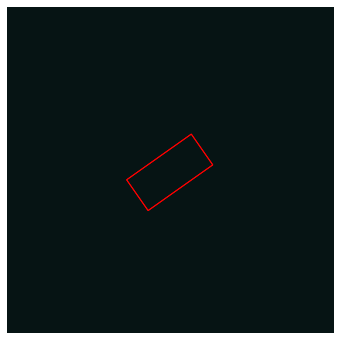

x =  [4303.27610089 4296.62996653 4276.63037875 4283.2763888 ]
y =  [19967.2078241  19976.73744192 19962.59472217 19953.0654056 ]
ra =  [102.01221566 102.01232521 102.01265413 102.01254458]
dec =  [70.27236244 70.27241535 70.27233666 70.27228376]
x =  [4303.27610089 4296.62996653 4276.63037875 4283.2763888 ]
y =  [19967.2078241  19976.73744192 19962.59472217 19953.0654056 ]
ra =  [102.01221566 102.01232521 102.01265413 102.01254458]
dec =  [70.27236244 70.27241535 70.27233666 70.27228376]


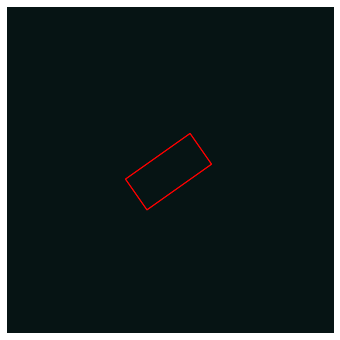

x =  [1524.27658253 1517.64597596 1497.79555079 1504.42603363]
y =  [19977.34547068 19986.87100359 19972.79381911 19963.26858789]
ra =  [102.05795403 102.05806344 102.05838973 102.05828032]
dec =  [70.27239673 70.27244959 70.27237118 70.27231833]
x =  [1524.27658253 1517.64597596 1497.79555079 1504.42603363]
y =  [19977.34547068 19986.87100359 19972.79381911 19963.26858789]
ra =  [102.05795403 102.05806344 102.05838973 102.05828032]
dec =  [70.27239673 70.27244959 70.27237118 70.27231833]


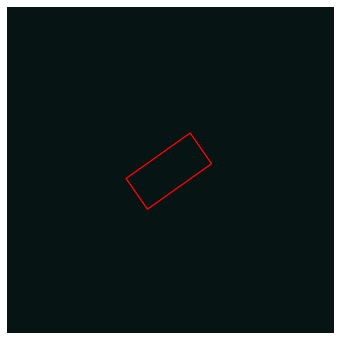

x =  [12651.55260384 12644.8098727  12624.25041858 12630.99288166]
y =  [20576.27597679 20585.85333237 20571.49377906 20561.91675014]
ra =  [101.8748035  101.8749143  101.87525302 101.87514222]
dec =  [70.27574255 70.2757958  70.27571617 70.27566291]
x =  [12651.55260384 12644.8098727  12624.25041858 12630.99288166]
y =  [20576.27597679 20585.85333237 20571.49377906 20561.91675014]
ra =  [101.8748035  101.8749143  101.87525302 101.87514222]
dec =  [70.27574255 70.2757958  70.27571617 70.27566291]


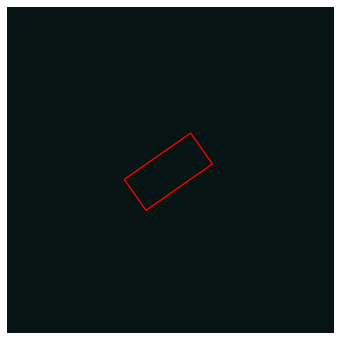

x =  [5900.2924858  5893.63690346 5873.53737242 5880.1928301 ]
y =  [20572.85338865 20582.39697044 20568.18736091 20558.6440801 ]
ra =  [101.98593735 101.98604701 101.98637773 101.98626807]
dec =  [70.27573455 70.27578754 70.27570853 70.27565554]
x =  [5900.2924858  5893.63690346 5873.53737242 5880.1928301 ]
y =  [20572.85338865 20582.39697044 20568.18736091 20558.6440801 ]
ra =  [101.98593735 101.98604701 101.98637773 101.98626807]
dec =  [70.27573455 70.27578754 70.27570853 70.27565554]


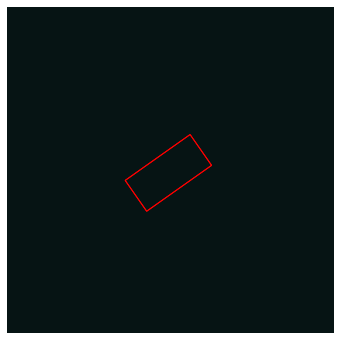

x =  [4707.81155376 4701.16261413 4681.12651102 4687.77532623]
y =  [20580.58828915 20590.13025938 20575.94846055 20566.40679149]
ra =  [102.00556713 102.00567672 102.00600632 102.00589673]
dec =  [70.27577235 70.27582532 70.27574643 70.27569346]
x =  [4707.81155376 4701.16261413 4681.12651102 4687.77532623]
y =  [20580.58828915 20590.13025938 20575.94846055 20566.40679149]
ra =  [102.00556713 102.00567672 102.00600632 102.00589673]
dec =  [70.27577235 70.27582532 70.27574643 70.27569346]


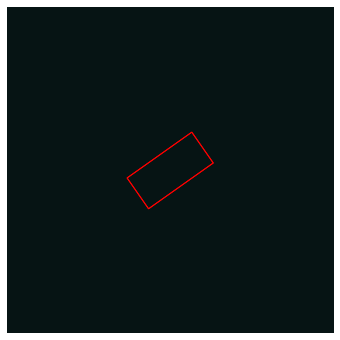

x =  [13047.48287291 13040.73718854 13020.13693108 13026.8823473 ]
y =  [21181.34138149 21190.92766988 21176.53007912 21166.94411727]
ra =  [101.86827294 101.86838379 101.86872326 101.86861241]
dec =  [70.27910125 70.27915455 70.27907472 70.27902141]
x =  [13047.48287291 13040.73718854 13020.13693108 13026.8823473 ]
y =  [21181.34138149 21190.92766988 21176.53007912 21166.94411727]
ra =  [101.86827294 101.86838379 101.86872326 101.86861241]
dec =  [70.27910125 70.27915455 70.27907472 70.27902141]


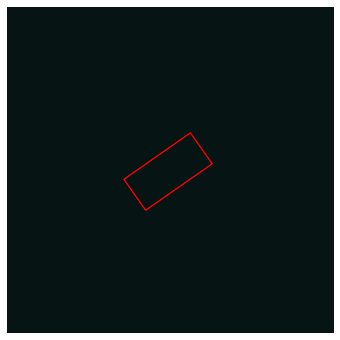

x =  [10265.03455686 10258.32971823 10237.92463036 10244.62924002]
y =  [21175.50413687 21185.07604012 21170.73114957 21161.15961211]
ra =  [101.91408291 101.91419321 101.91452929 101.914419  ]
dec =  [70.27908331 70.27913651 70.27905688 70.27900368]
x =  [10265.03455686 10258.32971823 10237.92463036 10244.62924002]
y =  [21175.50413687 21185.07604012 21170.73114957 21161.15961211]
ra =  [101.91408291 101.91419321 101.91452929 101.914419  ]
dec =  [70.27908331 70.27913651 70.27905688 70.27900368]


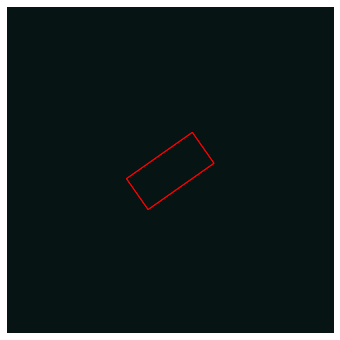

x =  [9872.10617114 9865.40621261 9845.02786767 9851.72759733]
y =  [21178.18804263 21187.75829722 21173.42233647 21163.85244776]
ra =  [101.92055202 101.92066225 101.92099787 101.92088764]
dec =  [70.27909933 70.27915251 70.27907292 70.27901974]
x =  [9872.10617114 9865.40621261 9845.02786767 9851.72759733]
y =  [21178.18804263 21187.75829722 21173.42233647 21163.85244776]
ra =  [101.92055202 101.92066225 101.92099787 101.92088764]
dec =  [70.27909933 70.27915251 70.27907292 70.27901974]


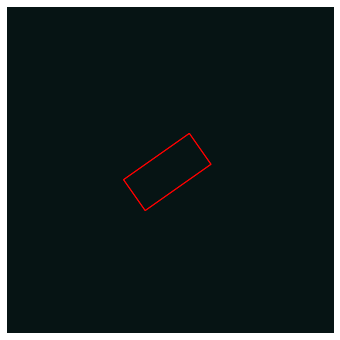

x =  [9479.61671559 9472.92163564 9452.57003712 9459.2648883 ]
y =  [21180.95441621 21190.52302045 21176.19598122 21166.62774297]
ra =  [101.92701391 101.92712408 101.92745923 101.92734906]
dec =  [70.27911557 70.27916875 70.27908919 70.27903602]
x =  [9479.61671559 9472.92163564 9452.57003712 9459.2648883 ]
y =  [21180.95441621 21190.52302045 21176.19598122 21166.62774297]
ra =  [101.92701391 101.92712408 101.92745923 101.92734906]
dec =  [70.27911557 70.27916875 70.27908919 70.27903602]


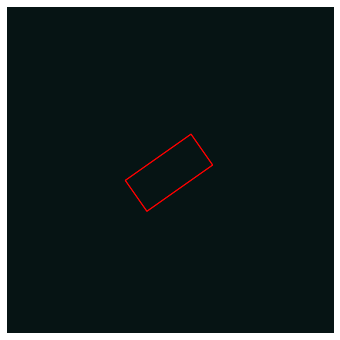

x =  [9087.56620539 9080.87600252 9060.5511539  9067.2411281 ]
y =  [21183.80311795 21193.37007011 21179.05194413 21169.48535804]
ra =  [101.93346858 101.93357869 101.93391337 101.93380326]
dec =  [70.27913204 70.2791852  70.27910569 70.27905253]
x =  [9087.56620539 9080.87600252 9060.5511539  9067.2411281 ]
y =  [21183.80311795 21193.37007011 21179.05194413 21169.48535804]
ra =  [101.93346858 101.93357869 101.93391337 101.93380326]
dec =  [70.27913204 70.2791852  70.27910569 70.27905253]


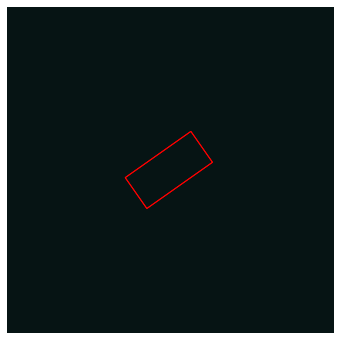

x =  [2720.11022037 2713.47184822 2693.5275069  2700.16575499]
y =  [21186.06141338 21195.61197337 21181.44816779 21171.89790923]
ra =  [102.03830183 102.03841135 102.03873937 102.03862985]
dec =  [70.27912271 70.27917571 70.27909686 70.27904386]
x =  [2720.11022037 2713.47184822 2693.5275069  2700.16575499]
y =  [21186.06141338 21195.61197337 21181.44816779 21171.89790923]
ra =  [102.03830183 102.03841135 102.03873937 102.03862985]
dec =  [70.27912271 70.27917571 70.27909686 70.27904386]


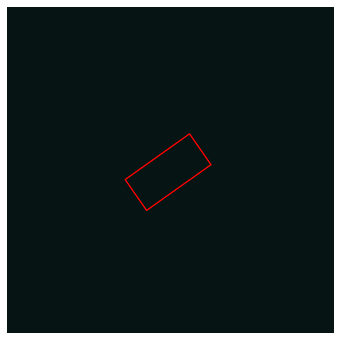

x =  [4313.1141909  4306.46638322 4286.42210346 4293.06978673]
y =  [21792.35605772 21801.9205939  21787.68998808 21778.12575305]
ra =  [102.01208524 102.01219487 102.01252469 102.01241506]
dec =  [70.2825022  70.2825553  70.28247612 70.28242302]
x =  [4313.1141909  4306.46638322 4286.42210346 4293.06978673]
y =  [21792.35605772 21801.9205939  21787.68998808 21778.12575305]
ra =  [102.01208524 102.01219487 102.01252469 102.01241506]
dec =  [70.2825022  70.2825553  70.28247612 70.28242302]


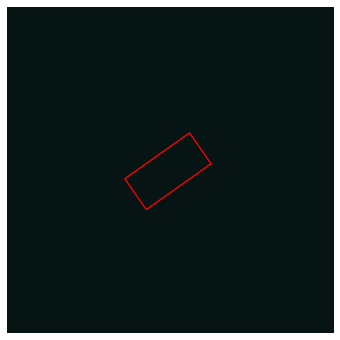

x =  [3517.52192356 3510.87856611 3490.87696925 3497.52020246]
y =  [21785.28307065 21794.8462884  21780.63483291 21771.07191643]
ra =  [102.0251858  102.02529539 102.02562445 102.02551486]
dec =  [70.28245779 70.28251087 70.28243178 70.2823787 ]
x =  [3517.52192356 3510.87856611 3490.87696925 3497.52020246]
y =  [21785.28307065 21794.8462884  21780.63483291 21771.07191643]
ra =  [102.0251858  102.02529539 102.02562445 102.02551486]
dec =  [70.28245779 70.28251087 70.28243178 70.2823787 ]


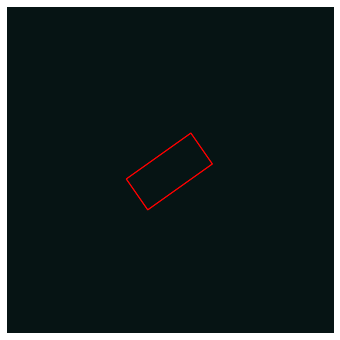

x =  [11862.95217841 11856.22961956 11835.68706578 11842.40939522]
y =  [22397.69125255 22407.29358844 22392.84559212 22383.24362157]
ra =  [101.88775502 101.88786558 101.88820413 101.88809358]
dec =  [70.28586633 70.28591971 70.28583956 70.28578618]
x =  [11862.95217841 11856.22961956 11835.68706578 11842.40939522]
y =  [22397.69125255 22407.29358844 22392.84559212 22383.24362157]
ra =  [101.88775502 101.88786558 101.88820413 101.88809358]
dec =  [70.28586633 70.28591971 70.28583956 70.28578618]


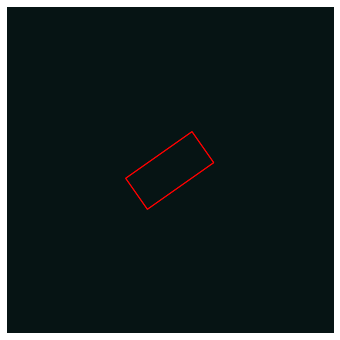

x =  [10263.53982261 10256.83705179 10236.40320604 10243.10574785]
y =  [22390.57412007 22400.16948986 22385.75866091 22376.16365685]
ra =  [101.91409631 101.91420661 101.91454327 101.91443297]
dec =  [70.2858337  70.28588703 70.28580703 70.2857537 ]
x =  [10263.53982261 10256.83705179 10236.40320604 10243.10574785]
y =  [22390.57412007 22400.16948986 22385.75866091 22376.16365685]
ra =  [101.91409631 101.91420661 101.91454327 101.91443297]
dec =  [70.2858337  70.28588703 70.28580703 70.2857537 ]


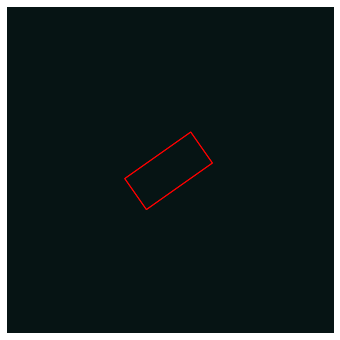

x =  [9870.28222643 9863.58433742 9843.17721441 9849.87487452]
y =  [22392.86920346 22402.46292523 22388.06103176 22378.46767581]
ra =  [101.92057296 101.9206832  101.9210194  101.92090916]
dec =  [70.28584756 70.28590087 70.28582091 70.2857676 ]
x =  [9870.28222643 9863.58433742 9843.17721441 9849.87487452]
y =  [22392.86920346 22402.46292523 22388.06103176 22378.46767581]
ra =  [101.92057296 101.9206832  101.9210194  101.92090916]
dec =  [70.28584756 70.28590087 70.28582091 70.2857676 ]


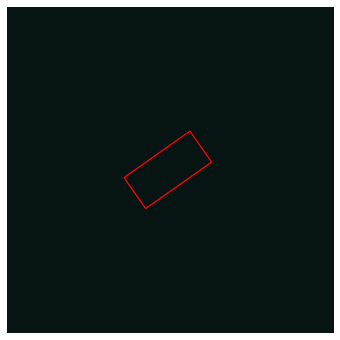

x =  [9477.46333448 9470.77032577 9450.38992901 9457.08270891]
y =  [22395.24683998 22404.83891203 22390.44594574 22380.85423962]
ra =  [101.9270424  101.92715257 101.92748831 101.92737814]
dec =  [70.28586164 70.28591494 70.28583502 70.28578172]
x =  [9477.46333448 9470.77032577 9450.38992901 9457.08270891]
y =  [22395.24683998 22404.83891203 22390.44594574 22380.85423962]
ra =  [101.9270424  101.92715257 101.92748831 101.92737814]
dec =  [70.28586164 70.28591494 70.28583502 70.28578172]


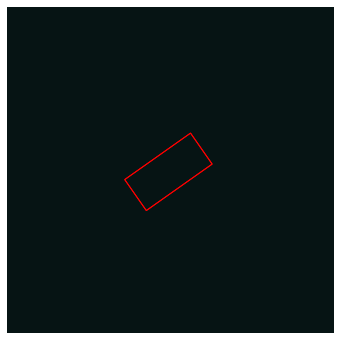

x =  [9085.08316214 9078.39503221 9058.04136519 9064.72926641]
y =  [22397.70688983 22407.29731045 22392.91326307 22383.32320847]
ra =  [101.93350462 101.93361473 101.93395    101.93383989]
dec =  [70.28587595 70.28592924 70.28584936 70.28579607]
x =  [9085.08316214 9078.39503221 9058.04136519 9064.72926641]
y =  [22397.70688983 22407.29731045 22392.91326307 22383.32320847]
ra =  [101.93350462 101.93361473 101.93395    101.93383989]
dec =  [70.28587595 70.28592924 70.28584936 70.28579607]


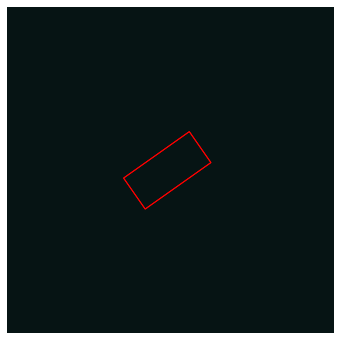

x =  [7888.86800299 7882.19474488 7861.92314474 7868.59617444]
y =  [22390.20805738 22399.79312125 22385.43711806 22375.8524205 ]
ra =  [101.95320546 101.95331538 101.95364922 101.95353931]
dec =  [70.28583483 70.28588807 70.28580831 70.28575506]
x =  [7888.86800299 7882.19474488 7861.92314474 7868.59617444]
y =  [22390.20805738 22399.79312125 22385.43711806 22375.8524205 ]
ra =  [101.95320546 101.95331538 101.95364922 101.95353931]
dec =  [70.28583483 70.28588807 70.28580831 70.28575506]


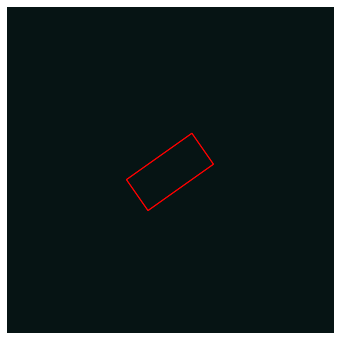

x =  [8278.68368018 8272.00658782 8251.69383484 8258.37069868]
y =  [22995.45650896 23005.05496382 22990.65711    22981.05902133]
ra =  [101.94678524 101.94689522 101.94722982 101.94711984]
dec =  [70.28919738 70.2892507  70.28917072 70.28911739]
x =  [8278.68368018 8272.00658782 8251.69383484 8258.37069868]
y =  [22995.45650896 23005.05496382 22990.65711    22981.05902133]
ra =  [101.94678524 101.94689522 101.94722982 101.94711984]
dec =  [70.28919738 70.2892507  70.28917072 70.28911739]


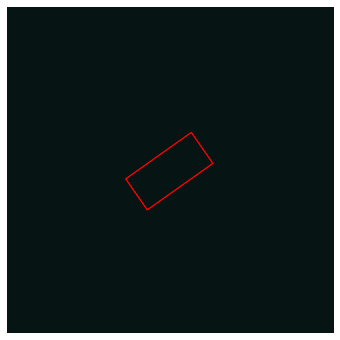

x =  [13884.28803334 13877.49779055 13856.93483881 13863.72481314]
y =  [16744.26191831 16753.82079271 16739.62348506 16730.06493702]
ra =  [101.85460823 101.85471965 101.85505815 101.85494673]
dec =  [70.25444422 70.25449738 70.25441868 70.25436552]
x =  [13884.28803334 13877.49779055 13856.93483881 13863.72481314]
y =  [16744.26191831 16753.82079271 16739.62348506 16730.06493702]
ra =  [101.85460823 101.85471965 101.85505815 101.85494673]
dec =  [70.25444422 70.25449738 70.25441868 70.25436552]


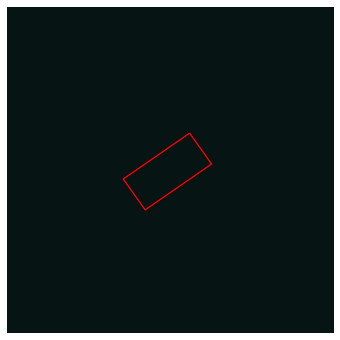

x =  [2768.53047721 2761.89377533 2741.99995379 2748.63653174]
y =  [19012.88369531 19022.39263259 19008.33239417 18998.82375844]
ra =  [102.03745222 102.03756165 102.03788864 102.03777921]
dec =  [70.26704992 70.26710269 70.26702442 70.26697165]
x =  [2768.53047721 2761.89377533 2741.99995379 2748.63653174]
y =  [19012.88369531 19022.39263259 19008.33239417 18998.82375844]
ra =  [102.03745222 102.03756165 102.03788864 102.03777921]
dec =  [70.26704992 70.26710269 70.26702442 70.26697165]


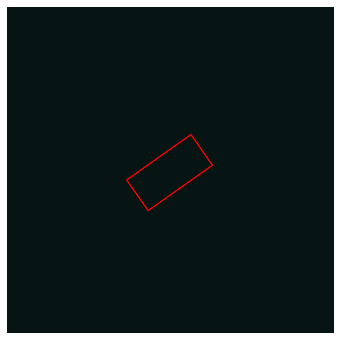

x =  [9465.56974634 9458.87432877 9438.53099729 9445.22618611]
y =  [20875.81202401 20885.37465486 20871.06455559 20861.50229074]
ra =  [101.92724691 101.92735708 101.92769206 101.92758189]
dec =  [70.27742037 70.27747351 70.27739404 70.27734091]
x =  [9465.56974634 9458.87432877 9438.53099729 9445.22618611]
y =  [20875.81202401 20885.37465486 20871.06455559 20861.50229074]
ra =  [101.92724691 101.92735708 101.92769206 101.92758189]
dec =  [70.27742037 70.27747351 70.27739404 70.27734091]


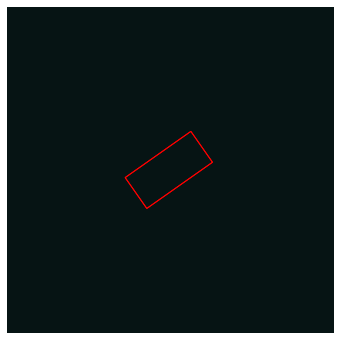

In [77]:
for target in targets:
    plot_slitlets(target, obsnum=21)